In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import skimage.transform
from tqdm import tqdm
from joblib import Parallel, delayed

ModuleNotFoundError: No module named 'seaborn'

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
#import seaborn as sns
from datetime import datetime
import os, re, gc, shutil, time
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import skimage.transform
from tqdm import tqdm
from joblib import Parallel, delayed

## WIMP spectrum sandbox

In [3]:
def mu(m1,m2):
    return m1*m2/(m1+m2)

def R_etheta_rel(E, theta, c_n, A_n, m_n, M_w=100, v_0=220, v_esc=544, sig_v=220/np.sqrt(2)):
    m_n *= 0.9315 #atomic mass to GeV
    w_n = np.sqrt(m_n*E*1e4*(2.99792**2)/(2*mu(m_n,M_w)**2))
    #print(w_n)
    #print(w_n-v_0*np.cos(theta))
    return c_n*(A_n**2)*( np.exp(-(w_n-v_0*np.cos(theta))**2/(2*sig_v**2)) - np.exp(-v_esc**2/(2*sig_v**2)) )

def R_etheta_abs(E, theta, c_n, A_n, m_n, M_w=100, sig_p=1e-46, rho=0.3, v_0=220, v_esc=544, sig_v=220/np.sqrt(2)):
    N_esc = sp.special.erf(v_esc/(np.sqrt(2)*sig_v)) - np.sqrt(2/sp.pi)*(v_esc/sig_v)*np.exp(-v_esc**2/(2*sig_v**2))
    #N_esc = 0.9933607713839784 # for v_esc=544, sig_v=220/np.sqrt(2)
    sig_p *= 1e44
    m_p = 0.93827 #GeV
    return 1.595*rho*sig_p/(2*M_w*N_esc*np.sqrt(2*np.pi*sig_v**2)*mu(m_p,M_w)**2)*R_etheta_rel(E, theta, c_n, A_n, m_n, M_w, v_0=v_0, v_esc=v_esc, sig_v=sig_v)

def E_max(m_n, M_w=100, v_esc=544, v_0=220):
    m_n *= 0.9315
    return 2*1e-4*(mu(m_n,M_w)**2)*((v_esc+v_0)**2)/m_n/2.99792**2

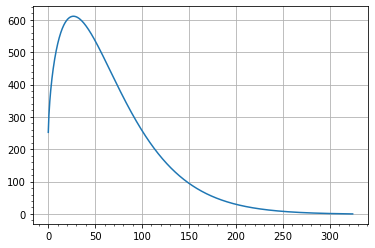

In [9]:
copa = R_etheta_rel(np.linspace(0.1,E_max(100),1000), theta=0, c_n=0.5, A_n=35, m_n=100)
copal = np.sum(copa)
plt.plot(np.linspace(0.1,E_max(100),1000), copa)#/copal)
plt.grid()
plt.minorticks_on()

In [7]:
np.linspace(0.1,E_max(100),1000)[np.argmin(copa>copa.max()/sp.e)]

9.836254188045292

In [6]:
E_max(m_n=107, M_w=10)

10.763750536837811

In [99]:
R_etheta_rel(10.56409,0,0.101,6,12.01)

763.9999988462197
543.9999988462197


2.0849180347795593e-10

In [12]:
E_max(12.01)

117.54171280378536

In [103]:
E_max(12.01)

10.564090031907433

In [165]:
carb_spectrum = np.zeros((100,100))
for i, E in enumerate(np.linspace(0, E_max(m_n=12.01), num=100, endpoint=False)):
    for j, theta in enumerate(np.linspace(0, sp.pi, num=100, endpoint=False)):
        carb_spectrum[i,j] = R_etheta_rel(E, theta, c_n=0.101, A_n=6, m_n=12.01, M_w=100)
        carb_spectrum[i,j] = max(0, carb_spectrum[i,j])

E_cut:10.56 keV,  E_peak:0.88 keV, M_w=100GeV


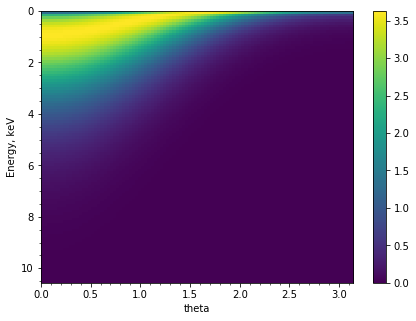

In [166]:
plt.figure(figsize=(7,5))
plt.imshow(carb_spectrum, extent=(0,sp.pi,E_max(m_n=12.01),0), aspect='auto')
plt.xlabel('theta')
plt.ylabel('Energy, keV')
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(12.01, M_w=100),2))+' keV,  E_peak:'+str(np.around(E_max(12.01, M_w=100, v_esc=0),2))+' keV, M_w=100GeV')

In [168]:
carb_spectrum = np.zeros((100,100))
for i, E in enumerate(np.linspace(0, E_max(m_n=12.01, M_w=1000), num=100, endpoint=False)):
    for j, M in enumerate(np.logspace(1, 3, num=100, endpoint=False)):
        carb_spectrum[i,j] = R_etheta_rel(E, theta=0, c_n=0.101, A_n=6, m_n=12.01, M_w=M)
        carb_spectrum[i,j] = max(0, carb_spectrum[i,j])

E_cut:12.77 keV,  E_peak:1.06 keV, theta=0


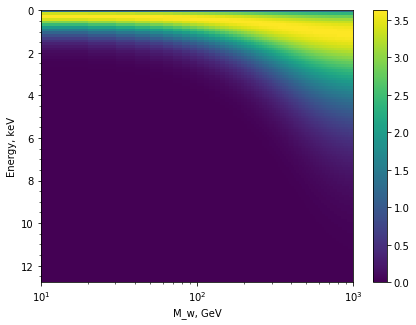

In [169]:
plt.figure(figsize=(7,5))
plt.imshow(carb_spectrum, extent=(10,1000,E_max(m_n=12.01, M_w=1000),0), aspect='auto')
plt.xlabel('M_w, GeV')
plt.xscale('log')
plt.ylabel('Energy, keV')
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(12.01, M_w=1000),2))+' keV,  E_peak:'+str(np.around(E_max(12.01, M_w=1000, v_esc=0),2))+' keV, theta=0')

In [170]:
arg_spectrum = np.zeros((100,100))
for i, E in enumerate(np.linspace(0, E_max(m_n=107.868, M_w=100), num=100, endpoint=False)):
    for j, theta in enumerate(np.linspace(0, sp.pi, num=100, endpoint=False)):
        arg_spectrum[i,j] = R_etheta_rel(E, theta, c_n=0.44, A_n=47, m_n=107.868, M_w=100)
        arg_spectrum[i,j] = max(0, arg_spectrum[i,j])

E_cut:29.18 keV,  E_peak:2.42 keV, M_w=100GeV


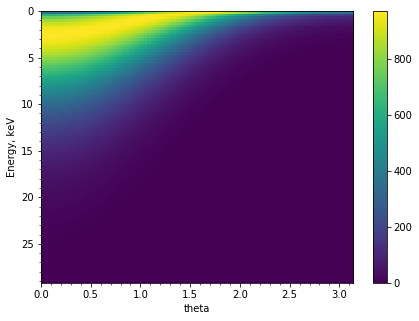

In [171]:
plt.figure(figsize=(7,5))
plt.imshow(arg_spectrum, extent=(0,sp.pi,E_max(m_n=107.868, M_w=100),0), aspect='auto')
plt.xlabel('theta')
plt.ylabel('Energy, keV')
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(107.868, M_w=100),2))+' keV,  E_peak:'+str(np.around(E_max(107.868, M_w=100, v_esc=0),2))+' keV, M_w=100GeV')

In [172]:
arg_spectrum = np.zeros((100,100))
for i, E in enumerate(np.linspace(0, E_max(m_n=107.868, M_w=1000), num=100, endpoint=False)):
    for j, M in enumerate(np.logspace(1, 3, num=100, endpoint=False)):
        arg_spectrum[i,j] = R_etheta_rel(E, theta=0, c_n=0.44, A_n=47, m_n=107.868, M_w=M)
        arg_spectrum[i,j] = max(0, arg_spectrum[i,j])

E_cut:96.86 keV,  E_peak:8.03 keV, theta=0


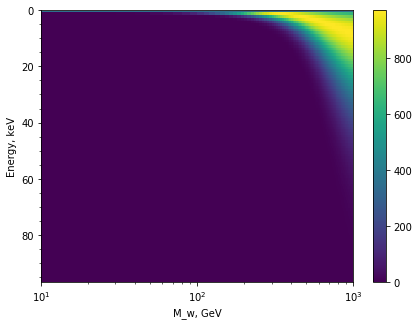

In [173]:
plt.figure(figsize=(7,5))
plt.imshow(arg_spectrum, extent=(10,1000,E_max(m_n=107.868, M_w=1000),0), aspect='auto')
plt.xlabel('M_w, GeV')
plt.xscale('log')
plt.ylabel('Energy, keV')
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(107.868, M_w=1000),2))+' keV,  E_peak:'+str(np.around(E_max(107.868, M_w=1000, v_esc=0),2))+' keV, theta=0')

In [174]:
br_spectrum = np.zeros((100,100))
for i, E in enumerate(np.linspace(0, E_max(m_n=79.9, M_w=100), num=100, endpoint=False)):
    for j, theta in enumerate(np.linspace(0, sp.pi, num=100, endpoint=False)):
        br_spectrum[i,j] = R_etheta_rel(E, theta, c_n=0.32, A_n=35, m_n=79.9, M_w=100)
        br_spectrum[i,j] = max(0, br_spectrum[i,j])

E_cut:28.56 keV,  E_peak:2.37 keV, M_w=100GeV


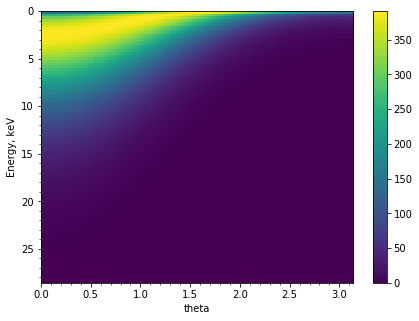

In [175]:
plt.figure(figsize=(7,5))
plt.imshow(br_spectrum, extent=(0,sp.pi,E_max(m_n=79.9, M_w=100),0), aspect='auto')
plt.xlabel('theta')
plt.ylabel('Energy, keV')
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(79.9, M_w=100),2))+' keV,  E_peak:'+str(np.around(E_max(79.9, M_w=100, v_esc=0),2))+' keV, M_w=100GeV')

In [217]:
br_spectrum = np.zeros((100,200))
for i, E in enumerate(np.linspace(0, E_max(m_n=79.9, M_w=1000), num=100, endpoint=False)):
    for j, M in enumerate(np.logspace(1, 3, num=200, endpoint=False)):
        br_spectrum[i,j] = R_etheta_rel(E, theta=0, c_n=0.32, A_n=35, m_n=79.9, M_w=M)
        br_spectrum[i,j] = max(0, br_spectrum[i,j])

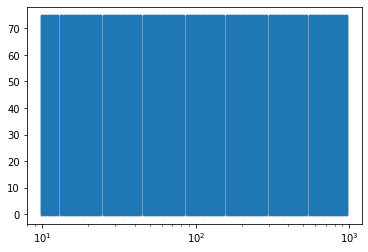

In [216]:
x = []
for i in np.linspace(0, E_max(m_n=79.9, M_w=1000), num=100, endpoint=False):
    x = np.append(x, [i]*100)
plt.scatter(list(np.logspace(1, 3, num=100, endpoint=False))*100, x, marker='.')
plt.xscale('log')

E_cut:75.26 keV,  E_peak:6.24 keV, theta=0


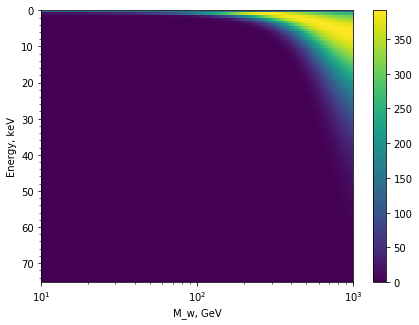

In [219]:
plt.figure(figsize=(7,5))
plt.imshow(br_spectrum, extent=(10,1000,E_max(m_n=79.9, M_w=1000),0), aspect='auto')
plt.xlabel('M_w, GeV')
plt.xscale('log')
plt.ylabel('Energy, keV')
#plt.xlim((100,1000))
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(79.9, M_w=1000),2))+' keV,  E_peak:'+str(np.around(E_max(79.9, M_w=1000, v_esc=0),2))+' keV, theta=0')

In [220]:
br_spectrum = np.zeros((100,200))
for i, E in enumerate(np.linspace(0, E_max(m_n=79.9, M_w=1000), num=100, endpoint=False)):
    for j, M in enumerate(np.logspace(1, 2, num=100, endpoint=False)):
        br_spectrum[i,j] = R_etheta_rel(E, theta=0, c_n=0.32, A_n=35, m_n=79.9, M_w=M)
        br_spectrum[i,j] = max(0, br_spectrum[i,j])

In [221]:
#br_spectrum = np.zeros((100,200))
for i, E in enumerate(np.linspace(0, E_max(m_n=79.9, M_w=1000), num=100, endpoint=False)):
    for j, M in enumerate(np.logspace(2, 3, num=100, endpoint=False)):
        j += 100
        br_spectrum[i,j] = R_etheta_rel(E, theta=0, c_n=0.32, A_n=35, m_n=79.9, M_w=M)
        br_spectrum[i,j] = max(0, br_spectrum[i,j])

E_cut:75.26 keV,  E_peak:6.24 keV, theta=0


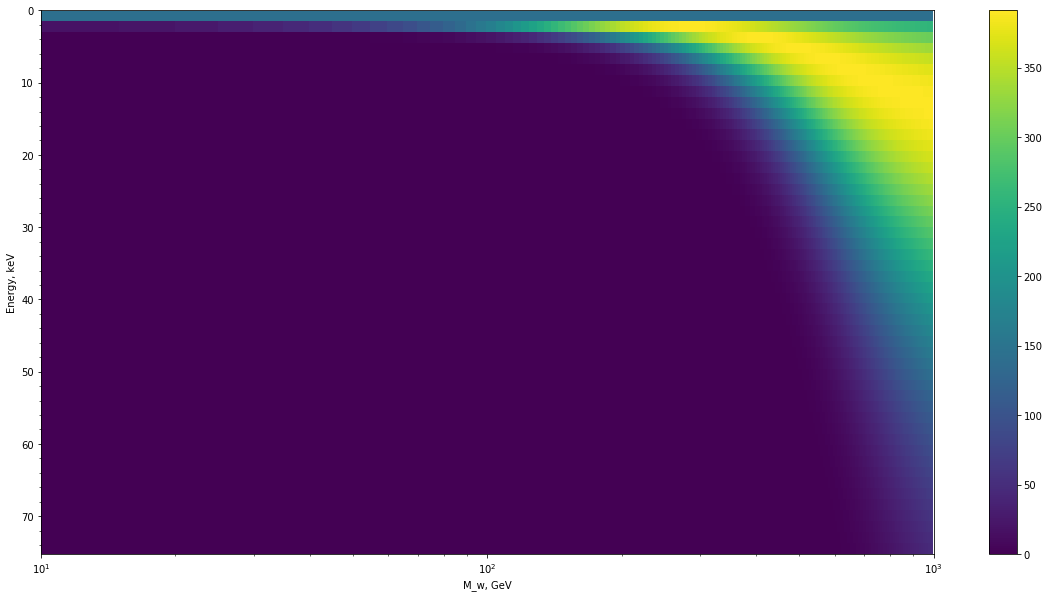

In [251]:
plt.figure(figsize=(20,10))
plt.imshow(br_spectrum[:50], extent=(10,1000,E_max(m_n=79.9, M_w=1000),0))
plt.xlabel('M_w, GeV')
plt.xscale('log')
plt.ylabel('Energy, keV')
#plt.xlim((100,1000))
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(79.9, M_w=1000),2))+' keV,  E_peak:'+str(np.around(E_max(79.9, M_w=1000, v_esc=0),2))+' keV, theta=0')

E_cut:75.26 keV,  E_peak:6.24 keV, theta=0


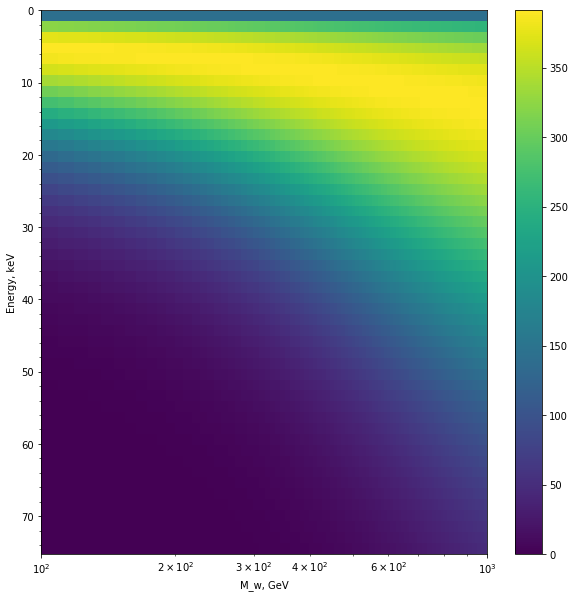

In [254]:
plt.figure(figsize=(10,10))
plt.imshow(br_spectrum[:50,100:], extent=(100,1000,E_max(m_n=79.9, M_w=1000),0))
plt.xlabel('M_w, GeV')
plt.xscale('log')
plt.ylabel('Energy, keV')
#plt.xlim((100,1000))
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(79.9, M_w=1000),2))+' keV,  E_peak:'+str(np.around(E_max(79.9, M_w=1000, v_esc=0),2))+' keV, theta=0')

In [224]:
bbr_spectrum = np.zeros((100,100))
for i, E in enumerate(np.linspace(0, E_max(m_n=79.9, M_w=1000), num=100, endpoint=False)):
    for j, M in enumerate(np.logspace(2, 3, num=100, endpoint=False)):
        bbr_spectrum[i,j] = R_etheta_rel(E, theta=0, c_n=0.32, A_n=35, m_n=79.9, M_w=M)
        bbr_spectrum[i,j] = max(0, bbr_spectrum[i,j])

E_cut:75.26 keV,  E_peak:6.24 keV, theta=0


<Figure size 504x360 with 0 Axes>

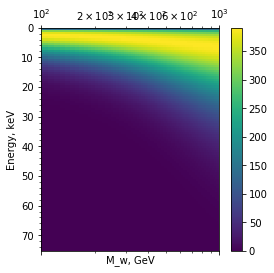

In [231]:
plt.figure(figsize=(7,5))
plt.matshow(bbr_spectrum, extent=(100,1000,E_max(m_n=79.9, M_w=1000),0), aspect='auto')
plt.xlabel('M_w, GeV')
plt.xscale('log')
plt.ylabel('Energy, keV')
#plt.xlim((100,1000))
plt.colorbar()
plt.minorticks_on()
#plt.xlim(0,2*sp.pi)
print('E_cut:'+str(np.around(E_max(79.9, M_w=1000),2))+' keV,  E_peak:'+str(np.around(E_max(79.9, M_w=1000, v_esc=0),2))+' keV, theta=0')

In [229]:
(br_spectrum[:,100:]-bbr_spectrum)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [185]:
np.logspace(1, 3, num=100, endpoint=False)

array([ 10.        ,  10.47128548,  10.96478196,  11.48153621,
        12.02264435,  12.58925412,  13.18256739,  13.80384265,
        14.45439771,  15.13561248,  15.84893192,  16.59586907,
        17.37800829,  18.19700859,  19.05460718,  19.95262315,
        20.89296131,  21.87761624,  22.90867653,  23.98832919,
        25.11886432,  26.30267992,  27.54228703,  28.84031503,
        30.1995172 ,  31.6227766 ,  33.11311215,  34.67368505,
        36.30780548,  38.01893963,  39.81071706,  41.68693835,
        43.65158322,  45.70881896,  47.86300923,  50.11872336,
        52.48074602,  54.95408739,  57.54399373,  60.25595861,
        63.09573445,  66.0693448 ,  69.18309709,  72.44359601,
        75.8577575 ,  79.43282347,  83.17637711,  87.096359  ,
        91.20108394,  95.4992586 , 100.        , 104.71285481,
       109.64781961, 114.81536215, 120.22644346, 125.89254118,
       131.82567386, 138.03842646, 144.54397707, 151.35612484,
       158.48931925, 165.95869074, 173.78008287, 181.97

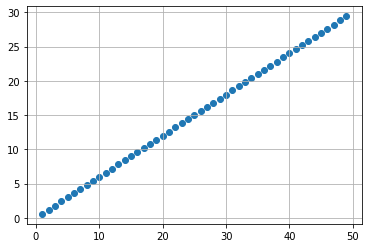

In [42]:
plt.scatter(range(50)[1:],np.linspace(0,30,num=50,endpoint=False)[1:])
plt.grid()

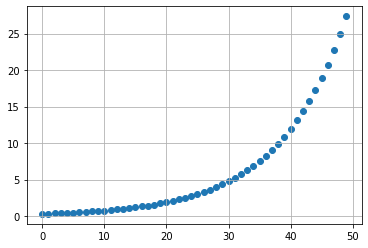

In [51]:
plt.scatter(range(50),np.geomspace(0.3,30,num=50,endpoint=False))
plt.grid()

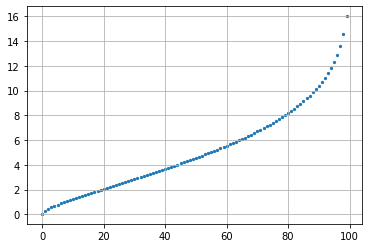

In [199]:
copa = np.linspace(0,1,100,endpoint=False); copa = sp.special.betaincinv(a,b, copa)
plt.scatter(range(100),copa*E+copa[1]*E/6, s=5)
plt.grid()

In [200]:
#E=97
copa*E+copa[1]*E/6

array([ 0.0423383 ,  0.29636811,  0.44517598,  0.57157958,  0.68594072,
        0.79249175,  0.89348078,  0.99027979,  1.08380296,  1.17469794,
        1.26344497,  1.35041293,  1.43589336,  1.52012215,  1.60329399,
        1.68557236,  1.76709657,  1.84798698,  1.92834879,  2.00827501,
        2.08784868,  2.16714464,  2.24623096,  2.32517003,  2.40401954,
        2.48283318,  2.56166128,  2.64055141,  2.71954873,  2.79869645,
        2.87803614,  2.95760804,  3.03745128,  3.11760416,  3.19810432,
        3.27898898,  3.36029505,  3.44205935,  3.52431874,  3.60711028,
        3.69047136,  3.77443988,  3.85905432,  3.94435395,  4.03037894,
        4.11717049,  4.20477104,  4.29322434,  4.38257569,  4.47287207,
        4.56416234,  4.65649742,  4.74993055,  4.84451746,  4.94031663,
        5.03738963,  5.13580131,  5.23562023,  5.33691894,  5.43977447,
        5.54426869,  5.65048887,  5.75852824,  5.86848659,  5.980471  ,
        6.09459667,  6.21098782,  6.32977876,  6.45111505,  6.57

In [197]:
def beta_eq(beta, e_m, ep):
    return (beta*(1-2*ep+beta*ep)*(1-ep)**2)/((1-2*ep+beta)**2 *(2-3*ep+beta))-e_m
ep = E_max(100, v_esc=0)/E_max(100); em = (ep*1.5)**2
b = sp.optimize.fsolve(beta_eq, 10, args=(em,ep)); a = (1-2*ep+b*ep)/(1-ep)
print(a,b)

[1.54373305] [7.01359762]


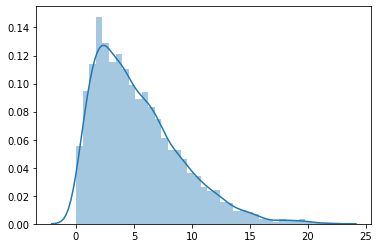

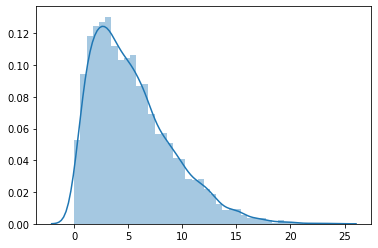

In [198]:
#copa = np.random.beta(a=2,b=5,size=5000)#; copa.sort()
#a=1.5; b=10.5; 
E=E_max(100)
copa = np.random.rand(5000); copa = sp.special.betaincinv(a,b, copa)
sns.distplot(copa*E)
plt.show()
copa = np.random.beta(a=a,b=b,size=5000)#; copa.sort()
#copa = np.random.rand(5000); copa = sp.special.betaincinv(2,5, copa)
sns.distplot(copa*E)
plt.show()

In [53]:
np.geomspace(1,100,num=50,endpoint=False)

array([ 1.        ,  1.0964782 ,  1.20226443,  1.31825674,  1.44543977,
        1.58489319,  1.73780083,  1.90546072,  2.08929613,  2.29086765,
        2.51188643,  2.7542287 ,  3.01995172,  3.31131121,  3.63078055,
        3.98107171,  4.36515832,  4.78630092,  5.2480746 ,  5.75439937,
        6.30957344,  6.91830971,  7.58577575,  8.31763771,  9.12010839,
       10.        , 10.96478196, 12.02264435, 13.18256739, 14.45439771,
       15.84893192, 17.37800829, 19.05460718, 20.89296131, 22.90867653,
       25.11886432, 27.54228703, 30.1995172 , 33.11311215, 36.30780548,
       39.81071706, 43.65158322, 47.86300923, 52.48074602, 57.54399373,
       63.09573445, 69.18309709, 75.8577575 , 83.17637711, 91.20108394])

## wimp.py backup

In [ ]:
#/usr/local/lib/python3.6/dist-packages/srim
## problem in RANGE.txt for 1 ion generation with lines like
## Total Ions calculated =.91
## pysrim expects number before dot
### cp /opt/pysrim/srim_fix.py /usr/local/lib/python3.6/dist-packages/srim/srim.py
# pip3 install joblib
# sh -c "xvfb-run -a python3.6 /opt/pysrim/wimp.py"

import os, shutil, gc
import srim

import numpy as np
from joblib import Parallel, delayed
# import scipy as sp
# import pandas as pd

### Important constants for calculations
N_wimps = 200000 # total n_wimps to be recoiled
n_bins = {'E':50, 'theta':30} # N_ex2N_theta binning of E-theta spectrum
M_w = 100 # GeV
track_3d = False # look at 3D coordinates or XY-projection
output_dir = os.path.abspath('/tmp/output') # store the output files

### Functions for simulating wimp-nuclei recoils
def mu(m1,m2):
    return m1*m2/(m1+m2)

def R_etheta_rel(E, theta, c_n, A_n, m_n, M_w=100, v_0=220, v_esc=544, sig_v=220/np.sqrt(2)):
    m_n *= 0.9315 #atomic mass to GeV
    w_n = np.sqrt(m_n*E*1e4*(2.99792**2)/(2*mu(m_n,M_w)**2))
    #print(w_n)
    #print(w_n-v_0*np.cos(theta))
    return c_n*(A_n**2)*( np.exp(-(w_n-v_0*np.cos(theta))**2/(2*sig_v**2)) - np.exp(-v_esc**2/(2*sig_v**2)) )

def R_etheta_abs(E, theta, c_n, A_n, m_n, M_w=100, sig_p=1e-46, rho=0.3, v_0=220, v_esc=544, sig_v=220/np.sqrt(2)):
    #N_esc = sp.special.erf(v_esc/(np.sqrt(2)*sig_v)) - np.sqrt(2/sp.pi)*(v_esc/sig_v)*np.exp(-v_esc**2/(2*sig_v**2))
    N_esc = 0.9933607713839784 # for v_esc=544, sig_v=220/np.sqrt(2)
    sig_p *= 1e44
    m_p = 0.93827 #GeV
    return 1.595*rho*sig_p/(2*M_w*N_esc*np.sqrt(2*np.pi*sig_v**2)*mu(m_p,M_w)**2)*R_etheta_rel(E, theta, c_n, A_n, m_n, M_w, v_0=v_0, v_esc=v_esc, sig_v=sig_v)

def E_max(m_n, M_w=100, v_esc=544, v_0=220):
    m_n *= 0.9315
    return 2*1e-4*(mu(m_n,M_w)**2)*((v_esc+v_0)**2)/m_n/2.99792**2


def dist(a,b):
    return np.sum((a-b)**2)

def find_track(coords):
    ### Find furthest points and track length
    start = coords[0]; end = coords[-1]
    max_dist = dist(start,end)
    while True:
        changed = False
        for i in range(len(coords)//2):
            if dist(coords[i],end)>max_dist:
                start = coords[i]; max_dist = dist(coords[i],end)
                changed = True
            elif dist(start,coords[-i])>max_dist:
                end = coords[-i]; max_dist = dist(start,coords[-i])
                changed = True
        if not changed: break
    return np.hstack((np.sqrt(max_dist)/10, (end-start)[0]/np.sqrt(max_dist), start, end))

def proc_exyz(exyz_dir='/tmp/srim/SRIM Outputs/'):
    with open(exyz_dir+'EXYZ.txt','r') as f:
        exyz = f.read()
        #print('\n'.join(mopa.split('\n')[:15]))
        # drop the backscatter
        exyz = np.array(exyz.split('\n'))[15:-1]
        mask = np.ones(len(exyz), dtype=bool)
        for i,line in enumerate(exyz):
            if '- ' in line: mask[i] = False
        exyz = exyz[mask]
        #
        exyz = np.array([s.split() for s in exyz], dtype=float)[:,:5]
    ions = np.unique(exyz[:,0], return_counts=True)
    in_step = 0
    tracks = np.zeros((0,8)) if track_3d else np.zeros((0,6))
    for i, steps in zip(ions[0],ions[1]):
        coords = exyz[in_step:in_step+steps, 2:] if track_3d else exyz[in_step:in_step+steps, 2:-1]
        tracks = np.vstack((tracks,find_track(coords)))
        in_step += steps
    return tracks


###
### Calculating spectrum
###
spectrum, tot_spec, spec_Etheta = {},{},{}
for name,el in elems.items():
    spectrum[name] = np.zeros((n_bins['E'],2*n_bins['theta']))
    spec_Etheta[name] = []
    nucl_par = {i:el[i] for i in ['c_n', 'A_n', 'm_n']}
    for i, E in enumerate(np.linspace(0, E_max(m_n=el['m_n'], M_w=M_w), num=n_bins['E']+1, endpoint=False)[1:]):
        # Starting from [1:] to avoid 0 keV, enpoint=False - end of spectrum
        spec_Etheta[name].append([])
        for j, theta in enumerate(np.linspace(0, np.pi, num=2*n_bins['theta'], endpoint=False)):
            spectrum[name][i,j] = R_etheta_rel(E, theta, M_w=M_w, **nucl_par)
            spectrum[name][i,j] = max(0, spectrum[name][i,j])
            spec_Etheta[name][i].append((E,theta))
    tot_spec[name] = np.sum(spectrum[name])
whole_spec = np.sum([tot for tot in tot_spec.values()])

int_spectrum = {}
for name, spec in spectrum.items():
    int_spectrum[name] = np.array(spec[:,:n_bins['theta']]/tot_spec[name]*(N_wimps*tot_spec[name]/whole_spec), dtype=int)
effic_bin = np.sum([sp_count.sum() for sp_count in int_spectrum.values()])/N_wimps
# part of tracks not lost due to integer bins and forward direction
print('effic_bin:\t',effic_bin)


###
### Simulating tracks
###
def energy_tracks(i_E, name, int_spec, n_bins=None, spec_Etheta=None, layer=None, srim_dir=None, output_dir=None, track_3d=None):
    track_theta = np.zeros((0,8)) if track_3d else np.zeros((0,6))
    for j in range(n_bins['theta']):
        if not int_spec[i_E,j]: continue
        E_ion = spec_Etheta[name][i_E][j][0]*1e3
        theta_ion = spec_Etheta[name][i_E][j][1]*180/np.pi
        N_ion = int_spec[i_E,j]
        #
        # SRIM simulation
        #
        ion = srim.Ion(name, energy=E_ion) #eV
        target = srim.Target([layer])
        TRIM_settings = {'calculation': 1, 'autosave':1, 'exyz':1, 'plot_xmax':100000, 'angle_ions': theta_ion}
        print(N_ion)
        trim = srim.TRIM(target, ion, number_ions=N_ion, **TRIM_settings)
        trim.run(srim_dir)
        os.makedirs(output_dir, exist_ok=True)
        shutil.copy(srim_dir+'/TRIM.IN', output_dir)
        shutil.copy(srim_dir+'/SRIM Outputs/EXYZ.txt', output_dir)
        shutil.copy(srim_dir+'/RANGE.txt', output_dir)
        del trim, target, ion; gc.collect();
        tracks_theta = np.vstack((tracks_theta, proc_exyz(srim_dir+'/SRIM Outputs/')))
    return track_theta

paral_params = dict(n_bins=n_bins, spec_Etheta=spec_Etheta, layer=layer, srim_dir=srim_dir, output_dir=output_dir, track_3d=track_3d)

for name, int_spec in int_spectrum.items():
    tracks_ion = np.zeros((0,8)) if track_3d else np.zeros((0,6))
    
    tracks_for_E = Parallel(n_jobs=6, verbose=10)(delayed(energy_tracks)(i_E, name, int_spec, **paral_params) for i_E in range(n_bins['E']) )
    for tr in tracks_for_E: tracks_ion = np.vstack((tracks_ion, tr))
    
#     for i in range(n_bins['E']):
#         for j in range(n_bins['theta']):
#             if not int_spec[i,j]: continue
#             E_ion = spec_Etheta[name][i][j][0]*1e3
#             theta_ion = spec_Etheta[name][i][j][1]*180/np.pi
#             N_ion = int_spec[i,j]
#             #
#             # SRIM simulation
#             #
#             ion = srim.Ion(name, energy=E_ion) #eV
#             target = srim.Target([layer])
#             TRIM_settings = {'calculation': 1, 'autosave':1, 'exyz':1, 'plot_xmax':100000, 'angle_ions': theta_ion}
#             print(N_ion)
#             trim = srim.TRIM(target, ion, number_ions=N_ion, **TRIM_settings)
#             trim.run(srim_dir)
#             os.makedirs(output_dir, exist_ok=True)
#             shutil.copy(srim_dir+'/TRIM.IN', output_dir)
#             shutil.copy(srim_dir+'/SRIM Outputs/EXYZ.txt', output_dir)
#             shutil.copy(srim_dir+'/RANGE.txt', output_dir)
#             #
#             tracks_ion = np.vstack((tracks_ion, proc_exyz(srim_dir+'/SRIM Outputs/')))
#             del trim, target, ion; gc.collect()
    np.savetxt(output_dir+'/tracks_'+name+'.csv', tracks_ion, delimiter=',')


In [31]:
import threading
def print_id(i):
    print(threading.get_ident())#os.getpid())
    return os.getpid()
    
np.unique(Parallel(n_jobs=5)(delayed(print_id)(i) for i in range(5000)), return_counts=True)

(array([30310, 30311, 30312, 30313, 30314]),
 array([1023, 1000,  993,  993,  991]))

In [30]:
import threading
def print_id(i):
    return threading.get_ident()#os.getpid())
    #return os.getpid()
    
np.unique(Parallel(n_jobs=5)(delayed(print_id)(i) for i in range(5000)), return_counts=True)

(array([139726870669120, 139768981665600, 139846947944256, 139880323811136,
        140293100226368]), array([ 999,  995, 1015,  989, 1002]))

In [21]:
os.getpid()

26803

In [2]:
copa = pd.read_csv('/mnt/ML-drive/Artem/70nm/Oct2019_N123gf/Carbon/100keV/0degr/imcheck_bfcl.txt',names=['vid','hid','grid']+['clid'+str(i) for i in range(8)]+['isol','n_pol'])
copa.head()

,vid,hid,grid,clid0,clid1,clid2,clid3,clid4,clid5,clid6,clid7,isol,n_pol
0,1,0,0,2319,2525,2736,2940,3143,3350,3554,3980,2,8
1,1,0,1,-1,-1,6532,-1,6673,-1,6799,6944,-2,4
2,1,0,4,-1,-1,-1,6597,6668,6736,6795,6939,-2,5
3,1,0,5,-1,-1,6528,6596,-1,-1,-1,-1,-2,2
4,1,0,6,6407,6464,6530,-1,6671,6740,6796,6942,-2,7


In [24]:
copa = pd.read_csv('/mnt/ML-drive/Artem/70nm/Oct2019_N123gf/fog/Scan1_07.10/imcheck_bfcl.txt',names=['vid','hid','grid']+['clid'+str(i) for i in range(8)]+['isol','n_pol'])
copa.head()

,vid,hid,grid,clid0,clid1,clid2,clid3,clid4,clid5,clid6,clid7,isol,n_pol
0,1,0,21,3582,3584,3586,3588,3590,3591,3593,3596,-1,8
1,1,0,22,3545,3547,3549,3551,3553,3555,3557,3561,-1,8
2,1,0,23,3498,3499,3500,3501,3502,3503,3504,3507,-1,8
3,1,0,24,3637,3639,3641,3644,3646,3649,3652,3657,-1,8
4,1,0,25,3636,3638,3640,3643,3645,3648,3651,3656,-1,8


In [25]:
(copa['isol']==2).sum()

0

In [2]:
copa = pd.read_csv('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_tmp/tracks_Ag.csv',names=['len','cos_theta','start_x','start_y','end_x','end_y'])
copa.head(5)

,len,cos_theta,start_x,start_y,end_x,end_y
0,27.984565,0.992083,0.0,0.0,277.630,-35.145
1,23.949861,0.978169,0.0,0.0,234.270,49.771
2,24.969139,0.955860,0.0,0.0,238.670,-73.365
3,12.699165,0.781988,0.0,0.0,99.306,-79.153
4,16.062132,0.983680,0.0,0.0,158.000,-28.900


In [4]:
file_list = [i for i in os.listdir('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_tmp/') if 'tracks_' in i]

['tracks_Br.csv',
 'tracks_C.csv',
 'tracks_Ag.csv',
 'tracks_O.csv',
 'tracks_N.csv',
 'tracks_I.csv',
 'tracks_H.csv']

In [7]:
np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_tmp/tracks_Ag.csv', delimiter=',').shape

(6246, 6)

In [14]:
np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_tmp/tracks_H.csv', delimiter=',').size

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output_tmp/tracks_H.csv"
  """Entry point for launching an IPython kernel.


0

# WIMP tracks

In [4]:
gevs = ['1000', '500', '100', '50', '10']

In [5]:
tracks_gev = {}
for gev in gevs:
    tracks = np.zeros((0,8))
    file_list = [i for i in os.listdir('/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/'+gev+'GeV/') if 'tracks_' in i]
    for file_name in file_list:
        tmp_tr = np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/'+gev+'GeV/'+file_name, delimiter=',')
        if tmp_tr.size>0: tracks = np.vstack((tracks, tmp_tr))
    tracks_gev[gev] = pd.DataFrame(tracks, columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])

/home/scanner-ml/anaconda3/envs/ML_new_fixed/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/1000GeV/tracks_N.csv"
  
/home/scanner-ml/anaconda3/envs/ML_new_fixed/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/1000GeV/tracks_H.csv"
  
/home/scanner-ml/anaconda3/envs/ML_new_fixed/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/500GeV/tracks_N.csv"
  
/home/scanner-ml/anaconda3/envs/ML_new_fixed/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/500GeV/tracks_H.csv"
  
/home/scanner-ml/anaconda3/envs/ML_new_fixed/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input fi

In [6]:
tracks_gev[gev].head()

,len,cos_theta,start_x,start_y,start_z,end_x,end_y,end_z
0,1.764605,0.928990,0.0000,0.0,0.0,16.39300,6.20500,2.03730
1,1.034457,0.223654,0.0000,0.0,0.0,2.31360,0.90311,10.04200
2,1.499877,0.934277,0.0000,0.0,0.0,14.01300,-2.94780,4.46200
3,1.829088,0.918983,0.0000,0.0,0.0,16.80900,-7.20810,-0.23876
4,2.765437,-0.056178,2.3073,0.0,0.0,0.75374,-25.62200,10.28900


In [7]:
tail_br = {'10':22.5, '50':143.7, '100':272.4, '500':614.3}
tail_ag = {'10':17, '50':100, '100':197, '500':515}
col_gev = {'10':'#9467bd', '50':'#d62728', '100':'#2ca02c', '500':'#ff7f0e', '1000':'#1f77b4'}
#['1f77b4', 'ff7f0e', '2ca02c', 'd62728', '9467bd', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']

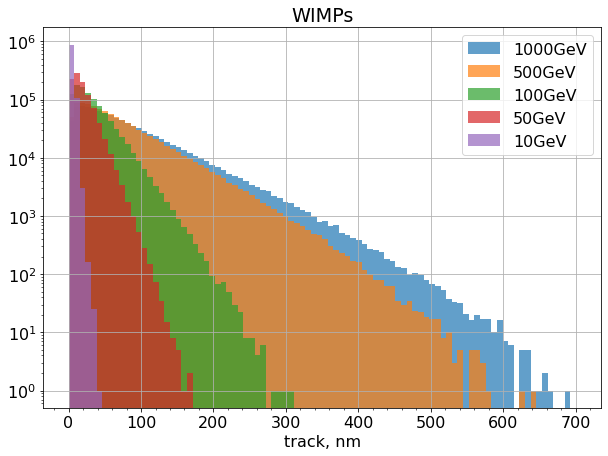

In [8]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 16})
for gev in gevs:
    plt.hist(tracks_gev[gev]['len'], bins=90, log=True, alpha=0.7, label=gev+'GeV', histtype='barstacked', range=(0,700))
plt.xlabel('track, nm')
plt.grid()
plt.legend()
plt.minorticks_on()
plt.title('WIMPs');
#np.median(tracks_df['len'].values)

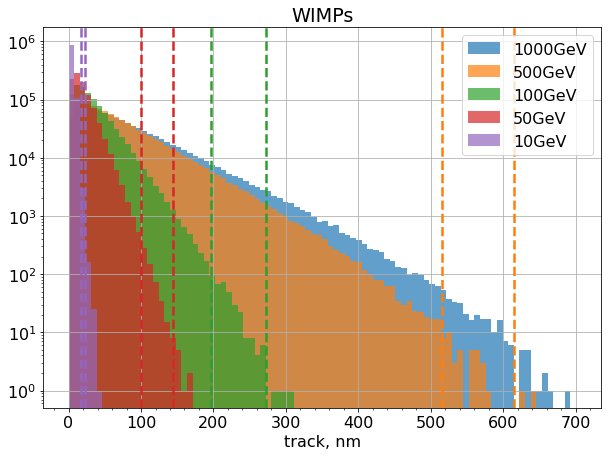

In [9]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 16})
for gev in gevs:
    plt.hist(tracks_gev[gev]['len'], bins=90, log=True, alpha=0.7, label=gev+'GeV', histtype='barstacked', range=(0,700), color=col_gev[gev])
    if gev!='1000': plt.axvline(x=tail_br[gev], color=col_gev[gev], linewidth=2.5, linestyle='--')
    if gev!='1000': plt.axvline(x=tail_ag[gev], color=col_gev[gev], linewidth=2.5, linestyle='--')
plt.xlabel('track, nm')
plt.grid()
plt.legend()
plt.minorticks_on()
plt.title('WIMPs');
#np.median(tracks_df['len'].values)

# WIMP tracks

In [3]:
gevs = ['1000', '500', '100', '50', '10']

In [4]:
tracks_gev = {}
for gev in gevs:
    tracks = np.zeros((0,8))
    file_list = [i for i in os.listdir('/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/'+gev+'GeV/') if 'tracks_' in i]
    for file_name in file_list:
        tmp_tr = np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/'+gev+'GeV/'+file_name, delimiter=',')
        if tmp_tr.size>0: tracks = np.vstack((tracks, tmp_tr))
    tracks_gev[gev] = pd.DataFrame(tracks, columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/1000GeV/tracks_N.csv"
  
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/1000GeV/tracks_H.csv"
  
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/500GeV/tracks_N.csv"
  
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output/wimp/500GeV/tracks_H.csv"
  
/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate

In [5]:
tracks_gev[gev].head()

,len,cos_theta,start_x,start_y,start_z,end_x,end_y,end_z
0,1.764605,0.928990,0.0000,0.0,0.0,16.39300,6.20500,2.03730
1,1.034457,0.223654,0.0000,0.0,0.0,2.31360,0.90311,10.04200
2,1.499877,0.934277,0.0000,0.0,0.0,14.01300,-2.94780,4.46200
3,1.829088,0.918983,0.0000,0.0,0.0,16.80900,-7.20810,-0.23876
4,2.765437,-0.056178,2.3073,0.0,0.0,0.75374,-25.62200,10.28900


In [6]:
tail_br = {'10':22.5, '50':143.7, '100':272.4, '500':614.3}
tail_ag = {'10':17, '50':100, '100':197, '500':515}
col_gev = {'10':'#9467bd', '50':'#d62728', '100':'#2ca02c', '500':'#ff7f0e', '1000':'#1f77b4'}
#['1f77b4', 'ff7f0e', '2ca02c', 'd62728', '9467bd', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']

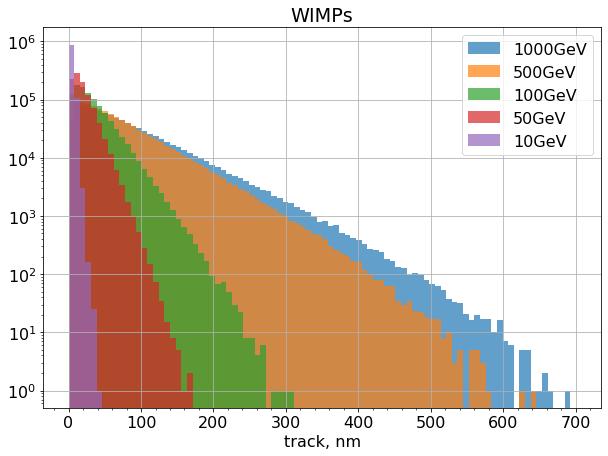

In [131]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 16})
for gev in gevs:
    plt.hist(tracks_gev[gev]['len'], bins=90, log=True, alpha=0.7, label=gev+'GeV', histtype='barstacked', range=(0,700))
plt.xlabel('track, nm')
plt.grid()
plt.legend()
plt.minorticks_on()
plt.title('WIMPs');
#np.median(tracks_df['len'].values)

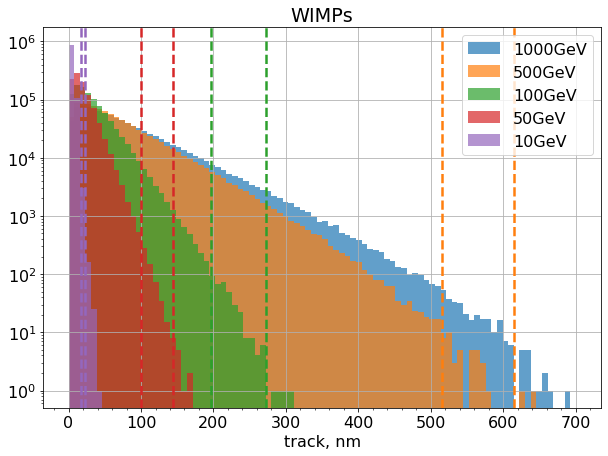

In [140]:
plt.figure(figsize=(10,7))
plt.rcParams.update({'font.size': 16})
for gev in gevs:
    plt.hist(tracks_gev[gev]['len'], bins=90, log=True, alpha=0.7, label=gev+'GeV', histtype='barstacked', range=(0,700), color=col_gev[gev])
    if gev!='1000': plt.axvline(x=tail_br[gev], color=col_gev[gev], linewidth=2.5, linestyle='--')
    if gev!='1000': plt.axvline(x=tail_ag[gev], color=col_gev[gev], linewidth=2.5, linestyle='--')
plt.xlabel('track, nm')
plt.grid()
plt.legend()
plt.minorticks_on()
plt.title('WIMPs');
#np.median(tracks_df['len'].values)

### archived

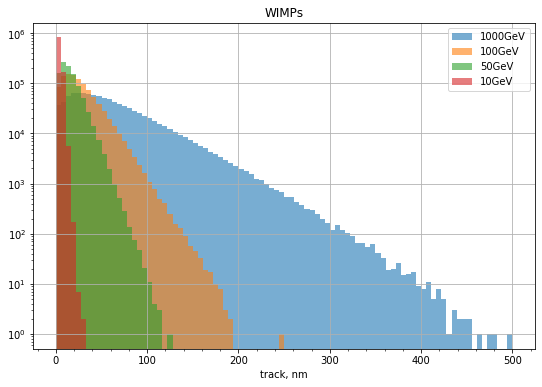

In [44]:
plt.figure(figsize=(9,6))
for gev in gevs:
    plt.hist(tracks_gev[gev]['len'], bins=90, log=True, alpha=0.6, label=gev+'GeV', histtype='barstacked', range=(0,500))
plt.xlabel('track, nm')
plt.grid()
plt.legend()
plt.minorticks_on()
plt.title('WIMPs');
#np.median(tracks_df['len'].values)

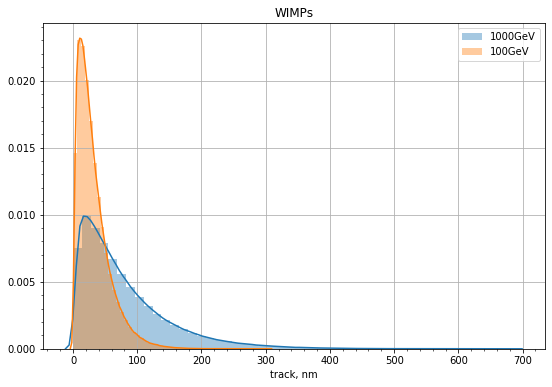

In [9]:
plt.figure(figsize=(9,6))
for gev in ['1000','100']:
    sns.distplot(tracks_gev[gev]['len'], label=gev+'GeV')
plt.grid()
plt.legend()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('WIMPs');
#np.median(tracks_df['len'].values)

In [10]:
for gev in gevs:
    print(gev+'GeV:\t',np.around(np.median(tracks_gev[gev]['len'].values), decimals=2))

1000GeV:	 59.21
500GeV:	 51.88
100GeV:	 25.14
50GeV:	 15.0
10GeV:	 3.84


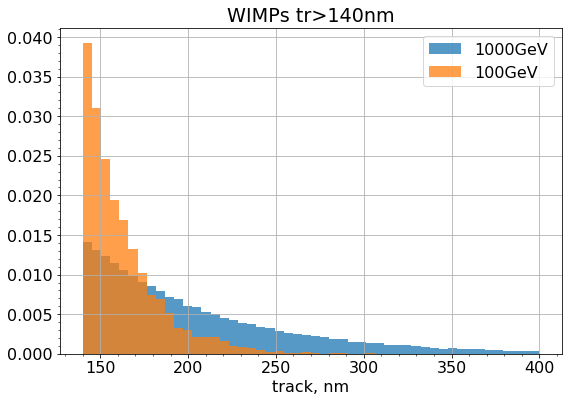

In [141]:
plt.figure(figsize=(9,6))
plt.rcParams.update({'font.size': 16})
for gev in ['1000','100']:
    plt.hist(tracks_gev[gev]['len'][tracks_gev[gev]['len']>140], bins=50, alpha=0.75, label=gev+'GeV', histtype='barstacked', density=True, range=(140,400))
plt.xlabel('track, nm')
plt.grid()
plt.legend()
plt.minorticks_on()
plt.title('WIMPs tr>140nm');
#np.median(tracks_df['len'].values)

In [12]:
for gev in gevs:
    print(gev+'GeV',np.around((tracks_gev[gev]['len']>140).sum()/tracks_gev[gev].shape[0]*100 , decimals=2),'%')

1000GeV 15.87 %
500GeV 11.52 %
100GeV 0.44 %
50GeV 0.0 %
10GeV 0.0 %


# Carbon tracks

In [13]:
kevs = ['30','40','50','60','100']

In [14]:
tracks_c = {}
for kev in kevs:
    tracks = np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output/carb/tracks_C'+kev+'.csv', delimiter=',')
    tracks_c[kev] = pd.DataFrame(tracks, columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])
tracks_c[kev].head()

,len,cos_theta,start_x,start_y,start_z,end_x,end_y,end_z
0,510.335430,0.464675,0.0,0.36550,0.0,2371.4000,4080.2,-1943.1000
1,228.919646,0.174437,0.0,2.04500,0.0,399.3200,2244.4,-229.8000
2,342.237172,0.819870,0.0,0.35885,0.0,2805.9000,1955.2,-134.7200
3,334.830458,0.159585,0.0,0.37189,0.0,534.3400,3194.2,851.5200
4,355.450143,0.000669,0.0,0.40409,0.0,2.3783,3554.9,-5.7941


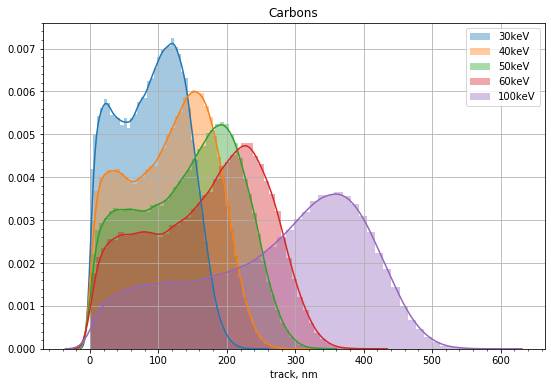

In [30]:
plt.figure(figsize=(9,6))
for kev in kevs:
    sns.distplot(tracks_c[kev]['len'], label=kev+'keV')
plt.grid()
plt.legend()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Carbons');
#np.median(tracks_df['len'].values)

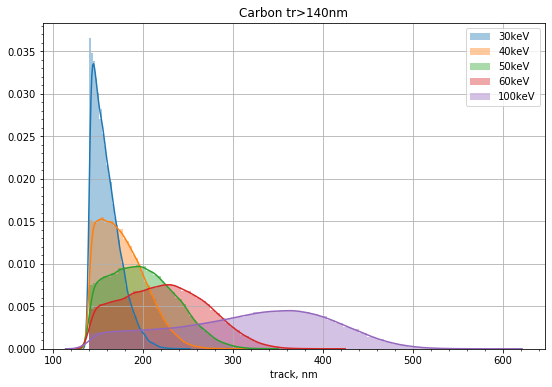

In [31]:
plt.figure(figsize=(9,6))
for kev in kevs:
    sns.distplot(tracks_c[kev]['len'][tracks_c[kev]['len']>140], label=kev+'keV')
plt.grid()
plt.legend()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Carbon tr>140nm');
#np.median(tracks_df['len'].values)

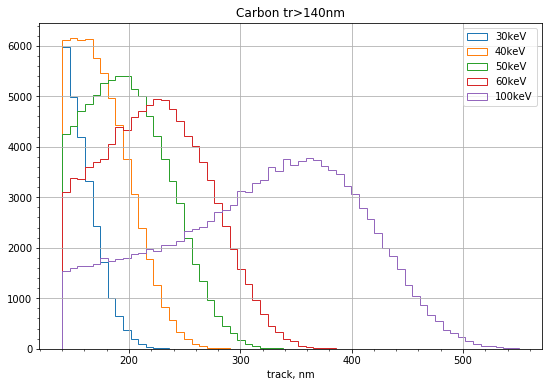

In [32]:
plt.figure(figsize=(9,6))
for kev in kevs:
    plt.hist(tracks_c[kev]['len'][tracks_c[kev]['len']>140], label=kev+'keV', bins=60, range=(140,550), histtype='step')
plt.grid()
plt.legend()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Carbon tr>140nm');
#np.median(tracks_df['len'].values)

# Combining WIMPs with Carbons

In [15]:
low_thr = 140; high_thr = 500
def track2bin(tracks, low_thr=140, high_thr=300, n_bins=100):
    bins = np.linspace(low_thr, high_thr, num=n_bins+1)[1:]
    binned_track = np.zeros(len(bins))
    tr_len_prev = low_thr
    for i, tr_len in enumerate(bins):
        binned_track[i] += (tracks[tracks<tr_len]>tr_len_prev).sum()
        tr_len_prev = tr_len
    return binned_track

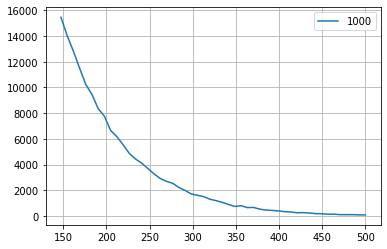

In [16]:
low_thr = 140; high_thr = 500; n_bins=50
plt.plot(np.linspace(low_thr, high_thr, num=n_bins+1)[1:], track2bin(tracks_gev['1000']['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr), label='1000')
#low_thr = 140; high_thr = 500; n_bins=50
#plt.plot(np.linspace(low_thr, high_thr, num=n_bins+1)[1:], track2bin(tracks_gev['1000']['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr), label='1000')
plt.grid()
plt.legend()

In [83]:
from scipy.optimize import lsq_linear, nnls
n_bins = 50; low_thr = 140; high_thr = 500
A = np.vstack(tuple([track2bin(tracks_c[kev]['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr) for kev in kevs] )).T
#A = np.vstack((track2bin(tracks_c30['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr), track2bin(tracks_c60['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr), track2bin(tracks_c100['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr))).T
b = track2bin(tracks_gev['100']['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr)

#lsq_linear(A,b, bounds=(0.01,0.99))
copa = nnls(A,b); print(copa)
copa[0]/copa[0].sum()

(array([0.01175024, 0.        , 0.        , 0.        , 0.        ]), 22.51418154242829)


array([1., 0., 0., 0., 0.])

In [17]:
from scipy.optimize import lsq_linear, nnls
n_bins = 60; low_thr = 140; high_thr = 300

for gev in ['100','500','1000']:
    high_thr = 300 + 200*((int(gev)-100)**0.2)/900**0.2
    for kevs_tmp in [kevs, ['30','60','100']]:
        A = np.vstack(tuple([track2bin(tracks_c[kev]['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr) for kev in kevs_tmp] )).T
        b = track2bin(tracks_gev[gev]['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr)

        #lsq_linear(A,b, bounds=(0.01,0.99))
        carb_perc, err = nnls(A,b)
        print(gev+'GeV: ',kevs_tmp,'keV combines:', np.around(carb_perc/carb_perc.sum()*100, decimals=2))
    print()

_='''A = np.vstack(tuple([track2bin(tracks_c[kev]['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr) for kev in kevs] )).T
b = track2bin(tracks_gev['100']['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr)

#lsq_linear(A,b, bounds=(0.01,0.99))
carb_perc, err = nnls(A,b)
print('100GeV: ',kevs,'keV combines:', np.around(carb_perc/carb_perc.sum()*100, decimals=2))

A = np.vstack(tuple([track2bin(tracks_c[kev]['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr) for kev in ['30','60','100']] )).T
b = track2bin(tracks_gev['100']['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr)

#lsq_linear(A,b, bounds=(0.01,0.99))
carb_perc, err = nnls(A,b)
print('100GeV: ',['30','60','100'],'keV combines:', np.around(carb_perc/carb_perc.sum()*100, decimals=2))'''

100GeV:  ['30', '40', '50', '60', '100'] keV combines: [98.25  0.    0.    1.75  0.  ]
100GeV:  ['30', '60', '100'] keV combines: [98.25  1.75  0.  ]

500GeV:  ['30', '40', '50', '60', '100'] keV combines: [52.35 21.59  9.71 13.15  3.2 ]
500GeV:  ['30', '60', '100'] keV combines: [72.94 26.48  0.58]

1000GeV:  ['30', '40', '50', '60', '100'] keV combines: [44.12 25.94  4.66 19.71  5.58]
1000GeV:  ['30', '60', '100'] keV combines: [67.39 29.68  2.93]



# OLD

In [85]:
# cm^3 = 1000 mm^3 = 1e12 um^3
10/3.44*0.5

1.4534883720930232

In [73]:
tracks = np.zeros((0,6))
file_list = [i for i in os.listdir('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_100GeV/') if 'tracks_' in i]
for file_name in file_list:
    tmp_tr = np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_100GeV/'+file_name, delimiter=',')
    if tmp_tr.size>0: tracks = np.vstack((tracks, tmp_tr))
tracks_df100 = pd.DataFrame(tracks, columns=['len','cos_theta','start_x','start_y','end_x','end_y'])
print(tracks_df100.shape)
tracks_df100.head(5)

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output_100GeV/tracks_N.csv"
  after removing the cwd from sys.path.


(994485, 6)


/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output_100GeV/tracks_H.csv"
  after removing the cwd from sys.path.


,len,cos_theta,start_x,start_y,end_x,end_y
0,1.740811,0.992756,0.0,0.0,17.2820,-2.0916
1,0.917621,0.899446,0.0,0.0,8.2535,4.0103
2,2.098021,0.330397,0.0,0.0,6.9318,-19.8020
3,1.629395,0.870384,0.0,0.0,14.1820,8.0227
4,0.980782,0.993951,0.0,0.0,9.7485,-1.0771


In [29]:
tracks = np.zeros((0,6))
file_list = [i for i in os.listdir('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_1000GeV/') if 'tracks_' in i]
for file_name in file_list:
    tmp_tr = np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_1000GeV/'+file_name, delimiter=',')
    if tmp_tr.size>0: tracks = np.vstack((tracks, tmp_tr))
tracks_df = pd.DataFrame(tracks, columns=['len','cos_theta','start_x','start_y','end_x','end_y'])
print(tracks_df.shape)
tracks_df.head(5)

/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output_1000GeV/tracks_N.csv"
  after removing the cwd from sys.path.


(994485, 6)


/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: loadtxt: Empty input file: "/mnt/ML-drive/Artem/Python/NEWS/simulate/output_1000GeV/tracks_H.csv"
  after removing the cwd from sys.path.


,len,cos_theta,start_x,start_y,end_x,end_y
0,3.238020,0.844096,0.0,0.0,27.332,17.3620
1,1.808592,0.924421,0.0,0.0,16.719,6.8975
2,2.558364,0.998372,0.0,0.0,25.542,1.4591
3,3.123386,0.997091,0.0,0.0,31.143,-2.3806
4,4.492003,0.879541,0.0,0.0,39.509,-21.3740


49.24584758206117

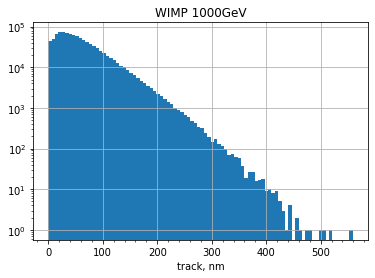

In [30]:
tracks_df.hist(column='len', bins=90, log=True)
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('WIMP 1000GeV')
np.median(tracks_df['len'].values)

49.24584758206117

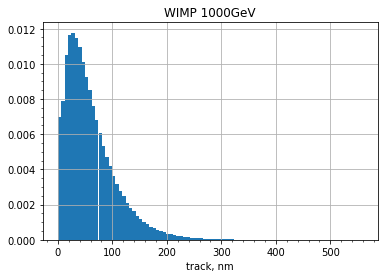

In [31]:
tracks_df.hist(column='len', bins=90, density=True)
#sns.distplot(tracks_df['len'])
#plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('WIMP 1000GeV')
np.median(tracks_df['len'].values)

49.24584758206117

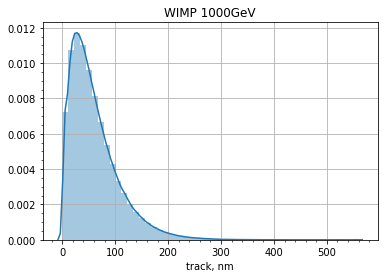

In [32]:
#tracks_df.hist(column='len', bins=90, density=True)
sns.distplot(tracks_df['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('WIMP 1000GeV')
np.median(tracks_df['len'].values)

In [33]:
(tracks_df['len']>140).sum()/tracks_df.shape[0]

0.06566313217393928

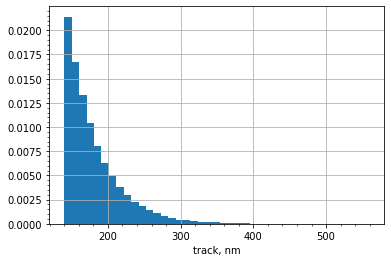

In [34]:
plt.hist(tracks_df['len'][tracks_df['len']>140], bins=41, density=True);
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()

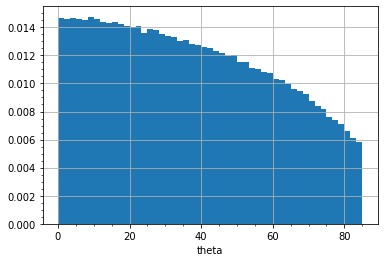

In [35]:
plt.hist(np.arccos(tracks_df['cos_theta'].values)*180/np.pi, bins=51, range=(0,85), density=True);
plt.grid()
plt.xlabel('theta')
plt.minorticks_on()

In [36]:
150*100/60/24

10.416666666666666

26.820323325900024

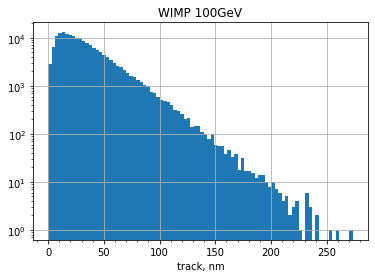

In [89]:
tracks_df.hist(column='len', bins=90, log=True)
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('WIMP 100GeV')
np.median(tracks_df['len'].values)

26.820323325900024

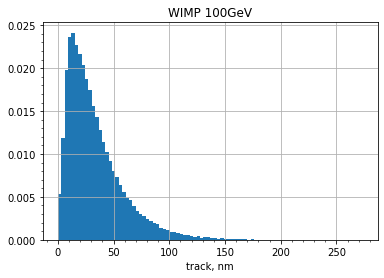

In [128]:
tracks_df.hist(column='len', bins=90, density=True)
#sns.distplot(tracks_df['len'])
#plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('WIMP 100GeV')
np.median(tracks_df['len'].values)

26.820323325900024

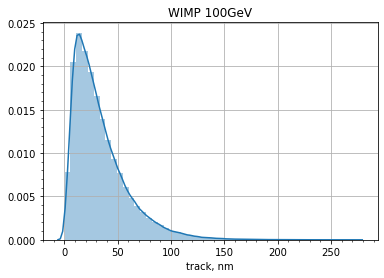

In [127]:
#tracks_df.hist(column='len', bins=90, density=True)
sns.distplot(tracks_df['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('WIMP 100GeV')
np.median(tracks_df['len'].values)

In [109]:
(tracks_df['len']>140).sum()/tracks_df.shape[0]

0.004509172384820053

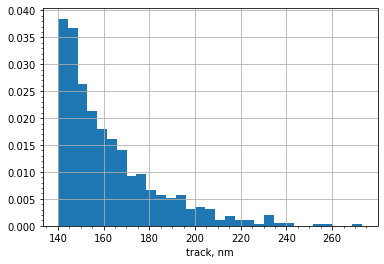

In [110]:
plt.hist(tracks_df['len'][tracks_df['len']>140], bins=31, density=True);
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()

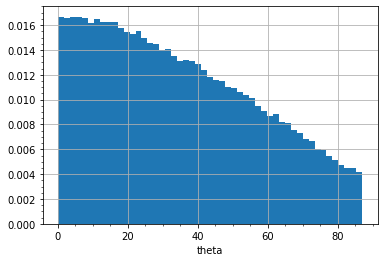

In [126]:
plt.hist(np.arccos(tracks_df['cos_theta'].values)*180/np.pi, bins=51, range=(0,87), density=True);
plt.grid()
plt.xlabel('theta')
plt.minorticks_on()

In [75]:
np.cos(87*np.pi/180)

0.052335956242943966

In [129]:
np.sum(tracks_df['cos_theta']<0.04)/tracks_df.shape[0]

0.059689119170984455

In [59]:
tracks_df.shape[0]

178525

In [47]:
copap = '''298
298
300
302
305
308
313
318
323
329
336
343
350
357
363
370
376
380
384
387
388
388
386
382
376
369
359
348
335
321
352
352
353
355
357
359
362
365
369
373
376
380
383
385
387
388
388
387
384
380
375
368
359
348
336
323
308
293
276
259
379
379
379
380
381
382
384
385
386
387
388
388
388
387
385
381
377
371
364
355
345
334
321
307
292
276
259
242
225
207
388
388
388
388
388
388
388
388
387
386
384
381
378
374
368
362
354
345
335
323
310
296
282
266
250
233
216
199
182
166
385
385
385
384
384
383
381
379
377
374
370
365
359
353
345
336
326
315
302
289
275
260
244
228
211
195
178
162
147
132
374
374
374
373
371
369
367
363
359
355
349
343
335
327
317
307
295
283
269
255
240
225
209
193
178
162
147
132
118
105
358
357
356
355
353
350
347
343
338
332
325
317
309
299
289
277
265
252
238
223
209
193
178
163
149
134
120
107
95
84
337
337
336
334
331
328
324
319
313
307
299
291
281
271
260
248
235
222
208
194
180
165
151
137
124
111
98
87
76
66
314
314
313
311
308
304
300
294
288
281
273
264
254
243
232
220
208
194
181
168
154
141
127
115
103
91
80
70
61
53
290
290
289
287
284
280
275
269
263
255
247
238
228
217
206
194
182
169
157
144
131
119
107
96
85
75
65
56
49
42
266
266
265
262
259
255
250
244
238
230
222
213
203
192
182
170
159
147
135
123
112
100
90
79
70
61
53
45
39
33
243
242
241
238
235
231
226
220
214
206
198
189
180
170
159
149
138
127
116
105
94
84
75
66
57
50
43
36
31
26
220
219
218
215
212
208
203
198
191
184
176
167
158
149
139
129
119
109
99
89
80
71
62
54
47
40
34
29
24
20
198
197
196
194
191
187
182
176
170
163
156
148
139
130
121
112
102
93
84
75
67
59
52
45
38
33
28
23
19
16
177
177
175
173
170
167
162
157
151
144
137
129
122
113
105
96
88
80
71
64
56
49
43
37
31
26
22
18
15
12
158
158
157
154
152
148
144
139
133
127
120
113
106
98
91
83
75
68
60
53
47
41
35
30
25
21
18
15
12
9
141
140
139
137
134
131
127
122
117
111
105
99
92
85
78
71
64
57
51
45
39
34
29
25
21
17
14
11
9
7
124
124
123
121
119
116
112
107
103
97
92
86
79
73
67
61
54
49
43
37
32
28
24
20
17
14
11
9
7
5
110
110
109
107
105
102
98
94
90
85
80
74
69
63
57
52
46
41
36
31
27
23
19
16
13
11
9
7
5
4
97
96
95
94
92
89
86
82
78
74
69
64
59
54
49
44
39
34
30
26
22
19
16
13
11
9
7
5
4
3
85
85
84
82
80
78
75
72
68
64
60
55
51
46
42
37
33
29
25
22
18
15
13
10
8
7
5
4
3
2
74
74
73
72
70
68
65
62
59
55
51
47
43
39
35
31
28
24
21
18
15
12
10
8
7
5
4
3
2
1
65
64
64
63
61
59
56
54
51
47
44
41
37
33
30
26
23
20
17
15
12
10
8
7
5
4
3
2
1
1
56
56
55
54
53
51
49
46
44
41
38
35
31
28
25
22
19
17
14
12
10
8
7
5
4
3
2
1
1
49
49
48
47
46
44
42
40
38
35
32
29
27
24
21
19
16
14
12
10
8
6
5
4
3
2
1
1
42
42
42
41
40
38
36
34
32
30
27
25
23
20
18
15
13
11
10
8
6
5
4
3
2
1
1
37
36
36
35
34
33
31
29
28
25
23
21
19
17
15
13
11
9
8
6
5
4
3
2
1
1
31
31
31
30
29
28
27
25
23
22
20
18
16
14
12
11
9
8
6
5
4
3
2
2
1
27
27
27
26
25
24
23
21
20
18
17
15
13
12
10
9
7
6
5
4
3
2
2
1
1
23
23
23
22
21
20
19
18
17
15
14
13
11
10
8
7
6
5
4
3
2
2
1
1
20
20
19
19
18
17
16
15
14
13
12
10
9
8
7
6
5
4
3
2
2
1
1
17
17
16
16
15
15
14
13
12
11
10
9
8
7
6
5
4
3
2
2
1
1
14
14
14
14
13
12
12
11
10
9
8
7
6
5
4
4
3
2
2
1
1
12
12
12
11
11
10
10
9
8
8
7
6
5
4
4
3
2
2
1
1
10
10
10
10
9
9
8
8
7
6
5
5
4
3
3
2
2
1
1
8
8
8
8
8
7
7
6
6
5
4
4
3
3
2
2
1
1
7
7
7
7
6
6
6
5
5
4
4
3
2
2
2
1
1
6
6
6
5
5
5
5
4
4
3
3
2
2
1
1
1
5
5
5
4
4
4
4
3
3
3
2
2
1
1
1
4
4
4
4
3
3
3
3
2
2
2
1
1
1
3
3
3
3
3
3
2
2
2
1
1
1
1
2
2
2
2
2
2
2
1
1
1
1
2
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
117
118
118
119
120
121
123
125
127
130
132
135
138
141
143
146
148
150
152
153
153
153
152
151
148
145
142
137
132
127
139
139
139
140
141
142
143
144
145
147
148
150
151
152
153
153
153
153
152
150
148
145
141
137
133
127
121
115
109
102
149
149
150
150
150
151
151
152
152
153
153
153
153
152
152
150
149
146
143
140
136
132
127
121
115
109
102
95
88
82
153
153
153
153
153
153
153
153
153
152
151
150
149
147
145
143
140
136
132
127
122
117
111
105
98
92
85
78
72
65
152
152
152
152
151
151
150
150
149
147
146
144
142
139
136
132
128
124
119
114
108
102
96
90
83
77
70
64
58
52
148
148
147
147
146
145
144
143
142
140
138
135
132
129
125
121
116
111
106
101
95
89
82
76
70
64
58
52
46
41
141
141
141
140
139
138
137
135
133
131
128
125
122
118
114
109
104
99
94
88
82
76
70
64
58
53
47
42
37
33
133
133
132
132
131
129
128
126
124
121
118
115
111
107
102
98
93
87
82
76
71
65
59
54
49
43
39
34
30
26
124
124
123
122
121
120
118
116
114
111
107
104
100
96
91
87
82
77
71
66
61
55
50
45
40
36
31
27
24
20
114
114
114
113
112
110
108
106
103
100
97
94
90
85
81
76
72
67
62
57
52
47
42
37
33
29
25
22
19
16
105
105
104
103
102
100
99
96
94
91
87
84
80
76
71
67
62
58
53
48
44
39
35
31
27
24
21
18
15
13
96
95
95
94
93
91
89
87
84
81
78
74
71
67
63
58
54
50
45
41
37
33
29
26
22
19
17
14
12
10
86
86
86
85
84
82
80
78
75
72
69
66
62
59
55
51
47
43
39
35
31
28
24
21
18
16
13
11
9
8
78
78
77
76
75
73
72
69
67
64
61
58
55
51
47
44
40
37
33
29
26
23
20
17
15
13
11
9
7
6
70
70
69
68
67
66
64
62
59
57
54
51
48
44
41
38
34
31
28
25
22
19
17
14
12
10
8
7
6
5
62
62
62
61
60
58
56
54
52
50
47
44
42
39
35
32
29
26
24
21
18
16
14
12
10
8
7
5
4
3
55
55
55
54
53
51
50
48
46
44
41
39
36
33
30
28
25
22
20
17
15
13
11
9
8
6
5
4
3
3
49
49
48
48
47
45
44
42
40
38
36
34
31
29
26
24
21
19
17
15
13
11
9
8
6
5
4
3
2
2
43
43
43
42
41
40
38
37
35
33
31
29
27
25
22
20
18
16
14
12
10
9
7
6
5
4
3
2
2
1
38
38
37
37
36
35
34
32
31
29
27
25
23
21
19
17
15
13
12
10
8
7
6
5
4
3
2
2
1
1
33
33
33
32
31
30
29
28
26
25
23
21
20
18
16
14
13
11
10
8
7
6
5
4
3
2
2
1
1
1
29
29
29
28
27
26
25
24
23
21
20
18
17
15
14
12
11
9
8
7
6
5
4
3
2
2
1
1
1
25
25
25
24
24
23
22
21
20
18
17
16
14
13
11
10
9
8
7
5
5
4
3
2
2
1
1
1
22
22
22
21
21
20
19
18
17
16
15
13
12
11
10
8
7
6
5
4
4
3
2
2
1
1
1
19
19
19
18
18
17
16
15
15
14
12
11
10
9
8
7
6
5
4
4
3
2
2
1
1
1
16
16
16
16
15
15
14
13
12
12
11
10
9
8
7
6
5
4
3
3
2
2
1
1
1
14
14
14
14
13
13
12
11
11
10
9
8
7
6
6
5
4
3
3
2
2
1
1
1
12
12
12
12
11
11
10
10
9
8
8
7
6
5
5
4
3
3
2
2
1
1
1
10
10
10
10
10
9
9
8
8
7
6
6
5
4
4
3
3
2
2
1
1
1
9
9
9
8
8
8
7
7
6
6
5
5
4
4
3
3
2
2
1
1
1
7
7
7
7
7
7
6
6
5
5
4
4
3
3
2
2
2
1
1
1
6
6
6
6
6
6
5
5
4
4
4
3
3
2
2
2
1
1
1
5
5
5
5
5
5
4
4
4
3
3
3
2
2
1
1
1
1
4
4
4
4
4
4
4
3
3
3
2
2
2
1
1
1
1
4
4
4
3
3
3
3
3
2
2
2
2
1
1
1
1
3
3
3
3
3
3
2
2
2
2
1
1
1
1
1
2
2
2
2
2
2
2
2
2
1
1
1
1
2
2
2
2
2
2
1
1
1
1
1
1
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
17
17
17
17
17
17
17
18
18
18
19
19
20
20
20
21
21
21
21
22
22
22
22
21
21
21
20
19
19
18
20
20
20
20
20
20
20
20
21
21
21
21
21
22
22
22
22
22
22
21
21
21
20
19
19
18
17
16
15
14
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
21
21
21
20
20
19
19
18
17
16
15
14
13
12
11
22
22
22
22
22
22
22
22
22
22
21
21
21
21
21
20
20
19
19
18
17
16
16
15
14
13
12
11
10
9
22
22
22
22
21
21
21
21
21
21
21
20
20
20
19
19
18
18
17
16
15
14
13
13
12
11
10
9
8
7
21
21
21
21
21
21
20
20
20
20
19
19
19
18
18
17
16
16
'''.split()

In [49]:
np.array(copap,dtype=int).sum()

174657

In [22]:
tracks_c60 = pd.DataFrame(np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_carb/tracks_C60.csv', delimiter=','), columns=['len','cos_theta','start_x','start_y','end_x','end_y'])
tracks_c60.head(5)

,len,cos_theta,start_x,start_y,end_x,end_y
0,108.409076,0.797138,0.0,0.059155,864.170,654.63
1,56.678564,-0.660878,385.1,75.481000,10.524,500.85
2,168.917924,0.650138,0.0,0.234660,1098.200,1283.70
3,208.405152,0.991866,0.0,0.219690,2067.100,265.49
4,277.854585,0.990842,0.0,0.013481,2753.100,375.19


(150000, 6)

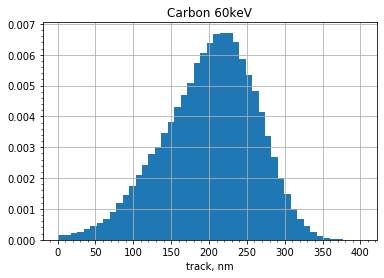

In [23]:
tracks_c60.hist(column='len', bins=47, density=True)
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Carbon 60keV')
tracks_c60.shape

(150000, 6)

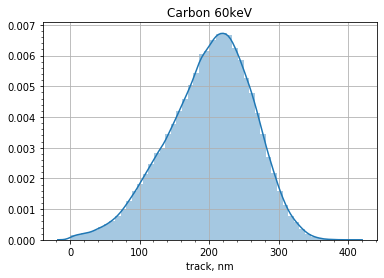

In [24]:
#tracks_c.hist(column='len', bins=47, density=True)
sns.distplot(tracks_c60['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Carbon 60keV')
tracks_c60.shape

In [25]:
tracks_c30 = pd.DataFrame(np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_carb/tracks_C30.csv', delimiter=','), columns=['len','cos_theta','start_x','start_y','end_x','end_y'])
tracks_c30.head(5)

,len,cos_theta,start_x,start_y,end_x,end_y
0,124.465925,0.891328,0.00,0.353210,1109.400,564.63
1,33.054218,-0.671878,296.94,134.160000,74.856,-110.66
2,125.582241,0.993771,0.00,0.370250,1248.000,140.32
3,36.493809,0.594265,0.00,0.031544,216.870,293.54
4,122.832246,0.994283,0.00,0.042148,1221.300,131.20


(150000, 6)

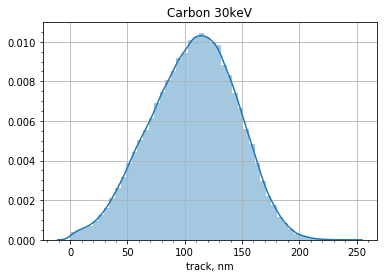

In [26]:
#tracks_c30.hist(column='len', bins=39, density=True)
sns.distplot(tracks_c30['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Carbon 30keV')
tracks_c30.shape

In [27]:
tracks_c100 = pd.DataFrame(np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_carb/tracks_C100.csv', delimiter=','), columns=['len','cos_theta','start_x','start_y','end_x','end_y'])
tracks_c100.head(5)

,len,cos_theta,start_x,start_y,end_x,end_y
0,345.378179,0.844929,0.0,0.045829,2918.2,1847.40
1,207.418628,0.991087,0.0,0.068244,2055.7,-276.24
2,326.987294,0.985176,0.0,0.077689,3221.4,-560.86
3,250.877054,0.974342,0.0,0.327650,2444.4,-564.33
4,306.007946,0.884912,0.0,0.040768,2707.9,1425.30


(150000, 6)

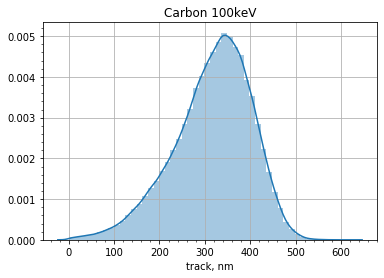

In [28]:
#tracks_c100.hist(column='len', bins=47, density=True) 
sns.distplot(tracks_c100['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Carbon 100keV')
tracks_c100.shape

In [46]:
low_thr = 140; high_thr = 300
def track2bin(tracks, low_thr=140, high_thr=300, n_bins=100):
    bins = np.linspace(low_thr, high_thr, num=n_bins+1)[1:]
    binned_track = np.zeros(len(bins))
    tr_len_prev = low_thr
    for i, tr_len in enumerate(bins):
        binned_track[i] += (tracks[tracks<tr_len]>tr_len_prev).sum()
        tr_len_prev = tr_len
    return binned_track

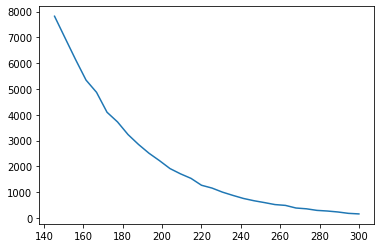

In [52]:
low_thr = 140; high_thr = 300; n_bins=30
plt.plot(np.linspace(low_thr, high_thr, num=n_bins+1)[1:], track2bin(tracks_df['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr))

In [72]:
from scipy.optimize import lsq_linear, nnls
n_bins = 100; low_thr = 80; high_thr = 300
A = np.vstack((track2bin(tracks_c30['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr), track2bin(tracks_c60['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr), track2bin(tracks_c100['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr))).T
b = track2bin(tracks_df['len'].values, n_bins=n_bins, low_thr=low_thr, high_thr=high_thr)

#lsq_linear(A,b, bounds=(0.01,0.99))
copa = nnls(A,b); print(copa)
copa[0]/copa[0].sum()

(array([2.11621929, 0.        , 0.14354173]), 17186.723838836904)


array([0.93647924, 0.        , 0.06352076])

In [111]:
tracks_c10 = pd.DataFrame(np.loadtxt('/mnt/ML-drive/Artem/Python/NEWS/simulate/output_carb/tracks_C10.csv', delimiter=','), columns=['len','cos_theta','start_x','start_y','end_x','end_y'])
tracks_c10.head(5)

,len,cos_theta,start_x,start_y,end_x,end_y
0,72.011662,0.973190,0.0,0.0,700.81,165.6300
1,38.530313,0.999992,0.0,0.0,385.30,1.5535
2,39.132087,0.996420,0.0,0.0,389.92,-33.0820
3,48.773337,0.977194,0.0,0.0,476.61,-103.5700
4,63.984056,0.936249,0.0,0.0,599.05,-224.8000


(10000, 6)

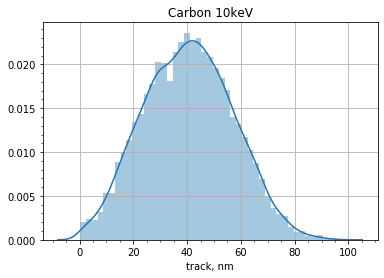

In [123]:
#tracks_c10.hist(column='len', bins=49, density=True)
sns.distplot(tracks_c10['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Carbon 10keV')
tracks_c10.shape

In [ ]:
f

## Ag tail test

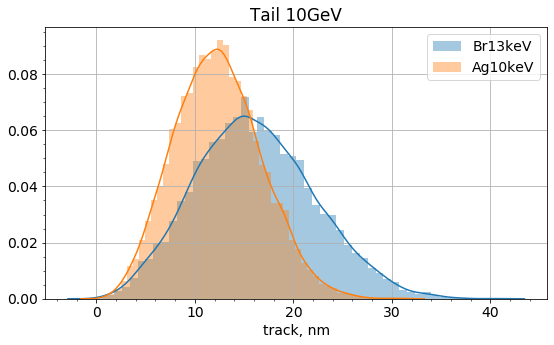

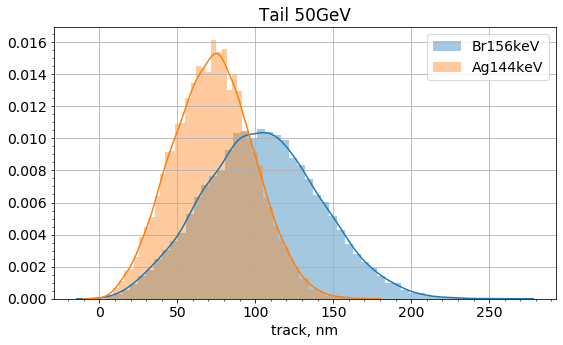

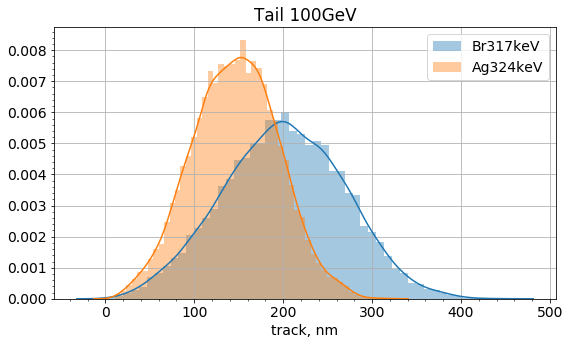

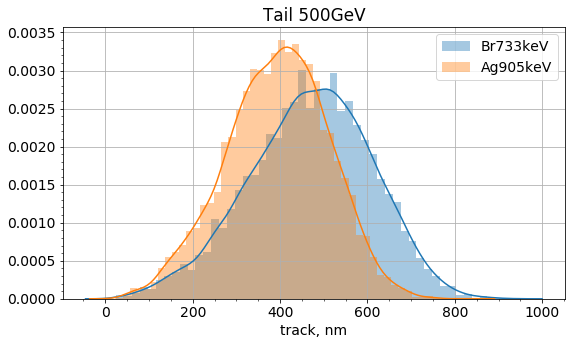

,name,median,quantile
0,Br_10GeV,15.8,22.5
1,Ag_10GeV,12.2,17.0
2,Br_50GeV,103.8,143.7
3,Ag_50GeV,73.0,99.9
4,Br_100GeV,200.7,272.4
5,Ag_100GeV,147.0,196.8
6,Br_500GeV,475.7,614.3
7,Ag_500GeV,398.5,515.0


In [125]:
gevs_test = ['10','50','100','500']
tracks_br, tracks_agmax = {}, {}
tails = {}
tails['name'], tails['median'], tails['quantile'] = [], [], []
for gev in gevs_test:
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(9,5))
    fdir = '/mnt/ML-drive/Artem/Python/NEWS/simulate/output/ion/br'+gev+'/'; fname = os.listdir(fdir)[0];# print(fname)
    tracks_br[gev] = pd.DataFrame(np.loadtxt(fdir+fname, delimiter=','), columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])
    sns.distplot(tracks_br[gev]['len'], label=fname.split('_')[1][:-4]+'keV')
    tails['name'].append('Br_'+gev+'GeV'); tails['median'].append(np.around(np.median(tracks_br[gev]['len']), decimals=1)); tails['quantile'].append(np.around(np.quantile(tracks_br[gev]['len'],0.85),decimals=1))
    
    fdir = '/mnt/ML-drive/Artem/Python/NEWS/simulate/output/ion/agmax/ag'+gev+'/'; fname = os.listdir(fdir)[0];# print(fname)
    tracks_agmax[gev] = pd.DataFrame(np.loadtxt(fdir+fname, delimiter=','), columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])
    sns.distplot(tracks_agmax[gev]['len'], label=fname.split('_')[1][:-4]+'keV')
    plt.grid()
    plt.xlabel('track, nm')
    plt.minorticks_on()
    plt.legend()
    plt.title('Tail '+gev+'GeV')
    #print('med',int(np.median(tracks_ag[gev]['len'])),'\t',int(np.median(tracks_agmax[gev]['len'])))
    #print('sig',int(np.quantile(tracks_ag[gev]['len'],0.85)),'\t',int(np.quantile(tracks_agmax[gev]['len'],0.85)))
    tails['name'].append('Ag_'+gev+'GeV'); tails['median'].append(np.around(np.median(tracks_agmax[gev]['len']), decimals=1)); tails['quantile'].append(np.around(np.quantile(tracks_agmax[gev]['len'],0.85),decimals=1))
    plt.show()
pd.DataFrame(tails)

In [83]:
fdir = '/mnt/ML-drive/Artem/Python/NEWS/simulate/output/ion/ag10/'; fname = os.listdir(fdir)[0]; print(fname)
tracks_ag10 = pd.DataFrame(np.loadtxt(fdir+fname, delimiter=','), columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])
tracks_ag10.head(5)

tracks_Ag10.csv


,len,cos_theta,start_x,start_y,start_z,end_x,end_y,end_z
0,5.316615,0.914699,0.0,0.0,0.0,48.631,2.64480,-21.323
1,12.714328,0.922031,0.0,0.0,0.0,117.230,43.64500,22.752
2,19.127398,0.917532,0.0,0.0,0.0,175.500,-17.37200,74.052
3,11.655903,0.762043,0.0,0.0,0.0,88.823,-0.55611,75.473
4,7.381206,0.967823,0.0,0.0,0.0,71.437,9.00240,16.246


med 12.07359663616753
sig 16.72647825989221


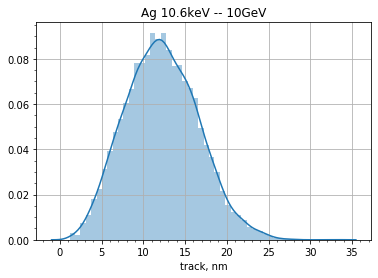

In [96]:
#tracks_c100.hist(column='len', bins=47, density=True) 
sns.distplot(tracks_ag10['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Ag 10.6keV -- 10GeV')
print('med',np.median(tracks_ag10['len']))
print('sig',np.quantile(tracks_ag10['len'],0.85))

In [85]:
fdir = '/mnt/ML-drive/Artem/Python/NEWS/simulate/output/ion/ag50/'; fname = os.listdir(fdir)[0]; print(fname)
tracks_ag50 = pd.DataFrame(np.loadtxt(fdir+fname, delimiter=','), columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])
tracks_ag50.head(5)

tracks_Ag143.csv


,len,cos_theta,start_x,start_y,start_z,end_x,end_y,end_z
0,60.409552,0.879762,0.0,0.0,0.0,531.46,-119.290,261.250
1,74.188828,0.831554,0.0,0.0,0.0,616.92,361.430,-197.930
2,39.514462,0.961623,0.0,0.0,0.0,379.98,-107.340,15.251
3,55.018697,0.510117,0.0,0.0,0.0,280.66,-53.275,-470.210
4,57.454887,0.949754,0.0,0.0,0.0,545.68,140.450,-112.310


med 72.09539190715748
sig 99.75814989071776


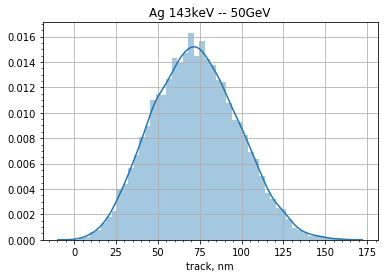

In [95]:
#tracks_c100.hist(column='len', bins=47, density=True) 
sns.distplot(tracks_ag50['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Ag 143keV -- 50GeV')
print('med',np.median(tracks_ag50['len']))
print('sig',np.quantile(tracks_ag50['len'],0.85))

In [87]:
fdir = '/mnt/ML-drive/Artem/Python/NEWS/simulate/output/ion/ag100/'; fname = os.listdir(fdir)[0]; print(fname)
tracks_ag100 = pd.DataFrame(np.loadtxt(fdir+fname, delimiter=','), columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])
tracks_ag100.head(5)

tracks_Ag322.csv


,len,cos_theta,start_x,start_y,start_z,end_x,end_y,end_z
0,111.788919,0.982298,0.0,0.0,0.0,1098.1,-60.435,-200.50
1,166.085027,0.966252,0.0,0.0,0.0,1604.8,-123.300,-409.68
2,218.558756,0.965141,0.0,0.0,0.0,2109.4,81.569,566.19
3,141.327144,0.952046,0.0,0.0,0.0,1345.5,-428.350,59.01
4,145.679564,0.990187,0.0,0.0,0.0,1442.5,-186.090,82.57


med 145.7377390910035
sig 195.89231348881665


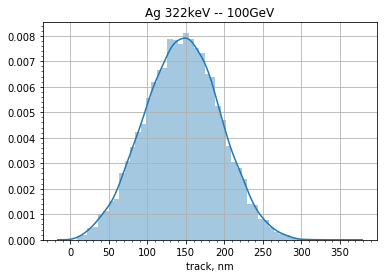

In [94]:
#tracks_c100.hist(column='len', bins=47, density=True) 
sns.distplot(tracks_ag100['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Ag 322keV -- 100GeV')
print('med',np.median(tracks_ag100['len']))
print('sig',np.quantile(tracks_ag100['len'],0.85))

In [89]:
fdir = '/mnt/ML-drive/Artem/Python/NEWS/simulate/output/ion/ag500/'; fname = os.listdir(fdir)[0]; print(fname)
tracks_ag500 = pd.DataFrame(np.loadtxt(fdir+fname, delimiter=','), columns=['len','cos_theta','start_x','start_y','start_z','end_x','end_y','end_z'])
tracks_ag500.head(5)

tracks_Ag900.csv


,len,cos_theta,start_x,start_y,start_z,end_x,end_y,end_z
0,433.674522,0.982465,0.0,0.0,0.0,4260.7,514.35,623.8900
1,265.282791,0.860968,0.0,0.0,0.0,2284.0,-500.58,-1253.1000
2,424.070163,0.954347,0.0,0.0,0.0,4047.1,-1266.60,-16.0110
3,615.439276,0.999384,0.0,0.0,0.0,6150.6,216.02,2.2878
4,486.506240,0.959186,0.0,0.0,0.0,4666.5,656.82,1208.8000


med 395.6891160734128
sig 514.2646895577734


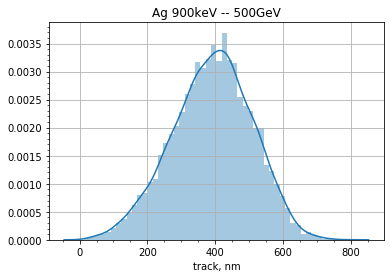

In [93]:
#tracks_c100.hist(column='len', bins=47, density=True) 
sns.distplot(tracks_ag500['len'])
plt.grid()
plt.xlabel('track, nm')
plt.minorticks_on()
plt.title('Ag 900keV -- 500GeV')
print('med',np.median(tracks_ag500['len']))
print('sig',np.quantile(tracks_ag500['len'],0.85))

In [106]:
print('Ag')
for m in [10,50,100,500]:
    print(str(m)+'GeV', E_max(m_n=108, M_w=m))

Ag
10GeV 10.682115956091106
50GeV 144.0329244190635
100GeV 324.7227613248299
500GeV 905.6277241601451


In [107]:
print('Br')
for m in [10,50,100,500]:
    print(str(m)+'GeV', E_max(m_n=80, M_w=m))

Br
10GeV 13.549725697670379
50GeV 156.06706561022685
100GeV 317.80378955776416
500GeV 733.1269510120453


In [82]:
Em = {10:10.6, 50:143, 100:322, 500:900}
for m in [10,50,100,500]:
    print(str(m)+'GeV\t', R_etheta_rel(Em[m], theta=0, c_n=0.445, A_n=47, m_n=108, M_w=m)/R_etheta_rel(E_max(m_n=108, M_w=m, v_esc=0), theta=0, c_n=0.445, A_n=47, m_n=108, M_w=m))

10GeV	 0.00015107740731323268
50GeV	 0.0001406333528183044
100GeV	 0.00016527564538898945
500GeV	 0.00012136888602947465


In [110]:
print('peak C vs Ag contribution')
for m in [10,50,100,500]:
    print(str(m)+'GeV', R_etheta_rel(E_max(m_n=12, M_w=m, v_esc=0), theta=0, c_n=0.1, A_n=6, m_n=12, M_w=m)/R_etheta_rel(E_max(m_n=108, M_w=m, v_esc=0), theta=0, c_n=0.445, A_n=47, m_n=108, M_w=m))
    #print(E_max(m_n=12, M_w=m),E_max(m_n=108, M_w=m))

peak C vs Ag contribution
10GeV 0.003662239764802824
50GeV 0.003662239764802824
100GeV 0.003662239764802824
500GeV 0.003662239764802824


In [113]:
print('peak Br vs Ag+Br contribution')
for m in [10,50,100,500]:
    print(str(m)+'GeV', R_etheta_rel(E_max(m_n=80, M_w=m, v_esc=0), theta=0, c_n=0.318, A_n=35, m_n=80, M_w=m)/(R_etheta_rel(E_max(m_n=80, M_w=m, v_esc=0), theta=0, c_n=0.318, A_n=35, m_n=80, M_w=m)+R_etheta_rel(E_max(m_n=108, M_w=m, v_esc=0), theta=0, c_n=0.445, A_n=47, m_n=108, M_w=m)))
    #print(E_max(m_n=12, M_w=m),E_max(m_n=108, M_w=m))

peak Br vs Ag contribution
10GeV 0.2838137633828881
50GeV 0.2838137633828881
100GeV 0.2838137633828881
500GeV 0.2838137633828881


## Expected number of events

In [8]:
long_tracks = {100:0.44/100, 500:0.1152, 1000:0.1587}

In [9]:
%%time
n_bins = 10000; #Mw = 1000
elems = {
    'Ag':{
        'st_n':0.105,
        'A_n':47,
        'm_n':107.868
    },
    'Br':{
        'st_n':0.101,
        'A_n':35,
        'm_n':79.904
    },
    'I':{
        'st_n':0.004,
        'A_n':53,
        'm_n':126.9
    },
    'O':{
        'st_n':0.117,
        'A_n':8,
        'm_n':15.999
    },
    'N':{
        'st_n':0.049,
        'A_n':7,
        'm_n':14.007
    },
    'C':{
        'st_n':0.214,
        'A_n':6,
        'm_n':12.011
    },
    'H':{
        'st_n':0.41,
        'A_n':1,
        'm_n':1.008
    }
}
for name,el in elems.items():
    elems[name]['c_n'] = np.round(el['st_n']*el['m_n']/np.sum([el['st_n']*el['m_n'] for el in elems.values()]),3)

for Mw in [100, 500, 1000]:
    R_tot = 0
    for name,el in elems.items():
        spectrum = np.zeros((n_bins,n_bins))
        nucl_par = {i:el[i] for i in ['c_n', 'A_n', 'm_n']}
        E_range = np.linspace(0, E_max(m_n=el['m_n'], M_w=Mw), num=n_bins+1, endpoint=False)[1:]
        delta = E_max(m_n=el['m_n'], M_w=Mw)/n_bins * np.pi/n_bins
        for i, E in enumerate(E_range):
            # Starting from [1:] to avoid 0 keV, enpoint=False - end of spectrum
            for j, theta in enumerate(np.linspace(0, np.pi, num=n_bins, endpoint=False)):
                spectrum[i,j] = R_etheta_abs(E, theta, M_w=Mw, sig_p=1e-41, **nucl_par)*delta
                spectrum[i,j] = max(0, spectrum[i,j])
        R_tot += np.sum(spectrum)
    print(str(Mw)+'GeV:', np.around(R_tot*long_tracks[Mw]/100/12, decimals=4),' for 10g*m; ', np.around(R_tot*10*long_tracks[Mw], decimals=1),' for 10kg*y')

100GeV: 0.0045  for 10g*m;  54.1  for 10kg*y


KeyboardInterrupt: 

In [14]:
%%time
n_bins = 100; #Mw = 1000
elems = {
    'Ag':{
        'st_n':0.105,
        'A_n':47,
        'm_n':107.868
    },
    'Br':{
        'st_n':0.101,
        'A_n':35,
        'm_n':79.904
    },
    'I':{
        'st_n':0.004,
        'A_n':53,
        'm_n':126.9
    },
    'O':{
        'st_n':0.117,
        'A_n':8,
        'm_n':15.999
    },
    'N':{
        'st_n':0.049,
        'A_n':7,
        'm_n':14.007
    },
    'C':{
        'st_n':0.214,
        'A_n':6,
        'm_n':12.011
    },
    'H':{
        'st_n':0.41,
        'A_n':1,
        'm_n':1.008
    }
}
for name,el in elems.items():
    elems[name]['c_n'] = np.round(el['st_n']*el['m_n']/np.sum([el['st_n']*el['m_n'] for el in elems.values()]),3)

for Mw in [100, 500, 1000]:
    R_tot = 0
    for name,el in elems.items():
        spectrum = np.zeros((n_bins,n_bins))
        nucl_par = {i:el[i] for i in ['c_n', 'A_n', 'm_n']}
        E_range = np.linspace(0, E_max(m_n=el['m_n'], M_w=Mw), num=n_bins+1, endpoint=False)[1:]
        delta = E_max(m_n=el['m_n'], M_w=Mw)/n_bins * np.pi/n_bins
        for i, E in enumerate(E_range):
            # Starting from [1:] to avoid 0 keV, enpoint=False - end of spectrum
            for j, theta in enumerate(np.linspace(0, np.pi, num=n_bins, endpoint=False)):
                spectrum[i,j] = R_etheta_abs(E, theta, M_w=Mw, sig_p=1e-41, **nucl_par)*delta
                spectrum[i,j] = max(0, spectrum[i,j])
        R_tot += np.sum(spectrum)
    print(str(Mw)+'GeV:', np.around(R_tot*long_tracks[Mw]/100/12, decimals=4),' for 10g*m; ', np.around(R_tot*10*long_tracks[Mw], decimals=1),' for 10kg*y')

100GeV: 0.0045  for 10g*m;  53.9  for 10kg*y
500GeV: 0.0618  for 10g*m;  741.0  for 10kg*y
1000GeV: 0.0501  for 10g*m;  601.8  for 10kg*y
CPU times: user 9.79 s, sys: 0 ns, total: 9.79 s
Wall time: 9.8 s


In [15]:
%%time
#check plot
n_bins = 200
R_m = []
for Mw in np.logspace(1,3,num=61):
    R_tot = 0
    for name,el in elems.items():
        spectrum = np.zeros((n_bins,n_bins))
        nucl_par = {i:el[i] for i in ['c_n', 'A_n', 'm_n']}
        E_range = np.linspace(0, E_max(m_n=el['m_n'], M_w=Mw), num=n_bins+1, endpoint=False)[1:]
        delta = E_max(m_n=el['m_n'], M_w=Mw)/n_bins * np.pi/n_bins
        for i, E in enumerate(E_range):
            # Starting from [1:] to avoid 0 keV, enpoint=False - end of spectrum
            for j, theta in enumerate(np.linspace(0, np.pi, num=n_bins, endpoint=False)):
                spectrum[i,j] = R_etheta_abs(E, theta, M_w=Mw, sig_p=1e-41, **nucl_par)*delta
                spectrum[i,j] = max(0, spectrum[i,j])
        R_tot += np.sum(spectrum)
    R_m.append(R_tot)

CPU times: user 13min 45s, sys: 64 ms, total: 13min 45s
Wall time: 13min 45s


Text(0.5, 1.0, 'Recoil rate/(kg*year)')

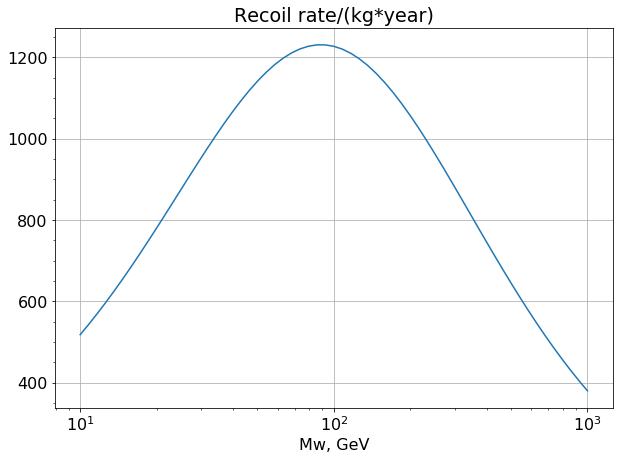

In [21]:
plt.figure(figsize=(10,7))
plt.plot(np.logspace(1,3,num=61), R_m)
plt.grid()
plt.xscale('log')
plt.xlabel('Mw, GeV')
plt.minorticks_on()
plt.title('Recoil rate/(kg*year)')